In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import catboost

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, LeakyReLU
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import regularizers

import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_SEED = 1

In [4]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [527]:
def roc_auc_create(probs, y_valid):
    probs = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_valid, probs)
    roc_auc = roc_auc_score(y_valid, probs)
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], label='Random', linestyle='--')
    plt.plot(fpr, tpr, label = 'Model')
    plt.title('ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [540]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
players = pd.read_csv('players_feats.csv')

## Изучим данные

In [5]:
train.head()

,map_id,team1_id,team2_id,map_name,who_win
0,289,6665,7718,Ancient,0
1,715,4411,10577,Inferno,0
2,157,11251,9455,Nuke,1
3,524,4608,7532,Mirage,0
4,404,8637,6667,Overpass,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   map_id    713 non-null    int64 
 1   team1_id  713 non-null    int64 
 2   team2_id  713 non-null    int64 
 3   map_name  713 non-null    object
 4   who_win   713 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 28.0+ KB


In [7]:
test.head()

,index,map_id,team1_id,team2_id,map_name
0,713,309,5973,5752,Dust2
1,714,541,5973,5752,Vertigo
2,715,1,8297,7020,Nuke
3,716,392,8297,7020,Mirage
4,717,684,8297,7020,Overpass


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   map_id    30 non-null     int64 
 1   team1_id  30 non-null     int64 
 2   team2_id  30 non-null     int64 
 3   map_name  30 non-null     object
dtypes: int64(3), object(1)
memory usage: 1.1+ KB


In [13]:
del test['index']

In [9]:
players.head()

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,p2_id,p2_total_kills,p2_headshots,p2_total_deaths,p2_kd_ratio,p2_damage_per_round,p2_grenade_damage_per_round,p2_maps_played,p2_rounds_played,p2_kills_per_round,p2_assists_per_round,p2_deaths_per_round,p2_saved_by_teammate_per_round,p2_saved_teammates_per_round,p2_rating,p2_kill_death,p2_kill_round,p2_rounds_with_kills,p2_kill_death_difference,p2_total_opening_kills,p2_total_opening_deaths,p2_opening_kill_ratio,p2_opening_kill_rating,p2_team_win_percent_after_first_kill,p2_first_kill_in_won_rounds,p3_id,p3_total_kills,p3_headshots,p3_total_deaths,p3_kd_ratio,p3_damage_per_round,p3_grenade_damage_per_round,p3_maps_played,p3_rounds_played,p3_kills_per_round,p3_assists_per_round,p3_deaths_per_round,p3_saved_by_teammate_per_round,p3_saved_teammates_per_round,p3_rating,p3_kill_death,p3_kill_round,p3_rounds_with_kills,p3_kill_death_difference,p3_total_opening_kills,p3_total_opening_deaths,p3_opening_kill_ratio,p3_opening_kill_rating,p3_team_win_percent_after_first_kill,p3_first_kill_in_won_rounds,p4_id,p4_total_kills,p4_headshots,p4_total_deaths,p4_kd_ratio,p4_damage_per_round,p4_grenade_damage_per_round,p4_maps_played,p4_rounds_played,p4_kills_per_round,p4_assists_per_round,p4_deaths_per_round,p4_saved_by_teammate_per_round,p4_saved_teammates_per_round,p4_rating,p4_kill_death,p4_kill_round,p4_rounds_with_kills,p4_kill_death_difference,p4_total_opening_kills,p4_total_opening_deaths,p4_opening_kill_ratio,p4_opening_kill_rating,p4_team_win_percent_after_first_kill,p4_first_kill_in_won_rounds,p5_id,p5_total_kills,p5_headshots,p5_total_deaths,p5_kd_ratio,p5_damage_per_round,p5_grenade_damage_per_round,p5_maps_played,p5_rounds_played,p5_kills_per_round,p5_assists_per_round,p5_deaths_per_round,p5_saved_by_teammate_per_round,p5_saved_teammates_per_round,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name,map_id
0,4954,90,42.2,112,0.80,76.3,5.9,6,156,0.58,0.24,0.72,0.13,0.05,0.98,0.80,0.58,62,-22,10,13,0.77,0.85,60.0,8.2,7412,106,35.8,119,0.89,66.8,5.6,7,181,0.59,0.09,0.66,0.07,0.06,0.91,0.89,0.59,75,-13,17,27,0.63,0.89,82.4,15.4,9078,46,65.2,54,0.85,76.9,4.5,3,75,0.61,0.16,0.72,0.07,0.07,0.93,0.85,0.61,34,-8,4,14,0.29,0.62,50.0,5.0,13843,110,40.9,139,0.79,53.8,3.0,8,204,0.54,0.06,0.68,0.06,0.09,0.83,0.79,0.54,80,-29,15,20,0.75,0.87,53.3,8.2,15165,140,40.7,133,1.05,83.9,9.2,8,198,0.71,0.17,0.67,0.07,0.07,1.16,1.04,0.70,84,5,25,12,2.08,1.28,84.0,25.0,6665,Ancient,635
1,5794,45,60.0,57,0.79,82.3,10.9,3,68,0.66,0.15,0.84,0.07,0.07,0.90,0.79,0.66,30,-12,5,10,0.50,0.79,40.0,10.0,5796,34,50.0,51,0.67,59.0,4.7,3,68,0.50,0.10,0.75,0.04,0.07,0.71,0.67,0.50,27,-17,5,4,1.25,0.94,0.0,0.0,7266,38,42.1,51,0.75,61.0,2.3,3,68,0.56,0.07,0.75,0.03,0.06,0.74,0.75,0.56,25,-13,6,8,0.75,0.91,83.3,25.0,12781,27,33.3,53,0.51,50.4,5.3,3,68,0.40,0.04,0.78,0.01,0.03,0.56,0.51,0.40,22,-26,7,13,0.54,0.86,57.1,20.0,14932,504,55.0,370,1.36,85.8,3.9,23,599,0.84,0.12,0.62,0.08,0.12,1.28,1.36,0.86,233,96,54,34,1.59,1.17,70.4,16.7,7532,Ancient,635
2,4954,156,51.9,167,0.93,63.5,3.4,10,265,0.59,0.10,0.63,0.11,0.11,0.95,0.93,0.59,107,-11,21,18,1.17,0.95,81.0,13.1,7412,125,35.2,135,0.93,68.7,5.7,8,211,0.59,0.13,0.64,0.07,0.07,0.98,0.93,0.59,91,-10,29,25,1.16,1.16,69.0,20.0,9078,73,50.7,79,0.92,72.0,1.2,4,109,0.67,0.12,0.72,0.13,0.06,0.98,0.92,0.67,43,-6,14,21,0.67,0.99,50.0,13.0,138

In [10]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486 entries, 0 to 1485
Columns: 128 entries, p1_id to map_id
dtypes: float64(80), int64(47), object(1)
memory usage: 1.5+ MB


In [11]:
# проверим столбцы на пропуски
# pd.set_option('display.max_rows', None)
players.isna().sum() 

p1_id                                   0
p1_total_kills                          0
p1_headshots                            0
p1_total_deaths                         0
p1_kd_ratio                             0
                                       ..
p5_team_win_percent_after_first_kill    4
p5_first_kill_in_won_rounds             0
team_id                                 0
map_name                                0
map_id                                  0
Length: 128, dtype: int64

team_win_percent_after_first_kill имеет пропуски, т.к. эти игроки не сделали 1-й кил, поэтому не подсчитывается показатель, установлю 0 вместо пропуска

In [12]:
players.fillna(0, inplace=True)

**объединим train и test для преобразования**

In [15]:
train['sample'] = 1
test['sample'] = 0

In [20]:
data = pd.concat([train, test]).reset_index(drop=True)

## Рассмотрим данные об играх

In [21]:
data.head()

,map_id,team1_id,team2_id,map_name,who_win,sample
0,289,6665,7718,Ancient,0.0,1
1,715,4411,10577,Inferno,0.0,1
2,157,11251,9455,Nuke,1.0,1
3,524,4608,7532,Mirage,0.0,1
4,404,8637,6667,Overpass,1.0,1


In [22]:
data.describe()

,map_id,team1_id,team2_id,who_win,sample
count,743.000000,743.000000,743.000000,713.000000,743.000000
mean,371.000000,7182.184388,7741.086137,0.458626,0.959623
std,214.629914,2186.391441,2290.975061,0.498635,0.196974
min,0.000000,4411.000000,4411.000000,0.000000,0.000000
25%,185.500000,5005.000000,5973.000000,0.000000,1.000000
50%,371.000000,6667.000000,7461.000000,0.000000,1.000000
75%,556.500000,8637.000000,9565.000000,1.000000,1.000000
max,742.000000,11726.000000,11726.000000,1.000000,1.000000


## Рассмотрим детально информацию об игроках

In [23]:
player_cols = players.columns
for column in player_cols:
    print(column)

p1_id
p1_total_kills
p1_headshots
p1_total_deaths
p1_kd_ratio
p1_damage_per_round
p1_grenade_damage_per_round
p1_maps_played
p1_rounds_played
p1_kills_per_round
p1_assists_per_round
p1_deaths_per_round
p1_saved_by_teammate_per_round
p1_saved_teammates_per_round
p1_rating
p1_kill_death
p1_kill_round
p1_rounds_with_kills
p1_kill_death_difference
p1_total_opening_kills
p1_total_opening_deaths
p1_opening_kill_ratio
p1_opening_kill_rating
p1_team_win_percent_after_first_kill
p1_first_kill_in_won_rounds
p2_id
p2_total_kills
p2_headshots
p2_total_deaths
p2_kd_ratio
p2_damage_per_round
p2_grenade_damage_per_round
p2_maps_played
p2_rounds_played
p2_kills_per_round
p2_assists_per_round
p2_deaths_per_round
p2_saved_by_teammate_per_round
p2_saved_teammates_per_round
p2_rating
p2_kill_death
p2_kill_round
p2_rounds_with_kills
p2_kill_death_difference
p2_total_opening_kills
p2_total_opening_deaths
p2_opening_kill_ratio
p2_opening_kill_rating
p2_team_win_percent_after_first_kill
p2_first_kill_in_won_r

выведем информацию только о 1-х игроках для удобства изучения, статистика по остальным игрокам идентичная

In [26]:
p1_cols = [x for x in player_cols if 'p1_' in x] + ['team_id', 'map_name', 'map_id']

In [27]:
p1_info = players[p1_cols]

изучим признаки игроков

In [29]:
p1_info.describe()

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,team_id,map_id
count,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000
mean,6808.845222,237.353297,45.623553,239.849260,0.990875,72.572678,5.262988,13.662853,364.810229,0.642517,0.131057,0.647941,0.090525,0.080599,1.027207,0.932086,0.611440,135.219381,-7.228802,30.784657,32.582100,0.994125,0.944717,69.579677,13.517900,7461.635262,371.000000
std,4031.792795,126.932320,9.999153,124.403672,0.237200,11.874143,2.626014,6.904256,185.463054,0.122343,0.035785,0.086608,0.026172,0.026832,0.180781,0.296034,0.168446,76.687939,41.149168,20.000321,20.774523,0.823332,0.265029,19.589502,6.088321,2255.926813,214.557636
min,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-127.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4411.000000,0.000000
25%,3669.000000,148.000000,41.000000,156.000000,0.870000,66.600000,3.500000,9.000000,237.250000,0.580000,0.110000,0.620000,0.080000,0.060000,0.940000,0.840000,0.560000,82.250000,-30.000000,16.000000,17.000000,0.710000,0.870000,66.700000,10.000000,5752.000000,185.250000
50%,7938.000000,224.000000,46.700000,227.000000,0.960000,72.500000,4.800000,13.000000,347.000000,0.640000,0.130000,0.660000,0.090000,0.080000,1.020000,0.930000,0.620000,134.000000,-7.000000,29.000000,31.000000,0.900000,0.960000,73.900000,13.200000,7020.000000,371.000000
75%,9115.000000,307.000000,51.100000,310.750000,1.080000,78.975000,6.600000,18.000000,476.000000,0.690000,0.150000,0.690000,0.110000,0.100000,1.100000,1.050000,0.680000,185.750000,9.000000,42.000000,45.000000,1.170000,1.050000,78.900000,17.000000,9455.000000,556.750000
max,14359.000000,769.000000,81.800000,711.000000,3.890000,152.400000,21.000000,41.000000,1097.000000,1.670000,0.320000,0.880000,0.190000,0.190000,2.550000,3.890000,1.670000,381.000000,222.000000,117.000000,111.000000,20.000000,1.780000,100.000000,50.000000,11726.000000,742.000000


Признаки соответствует статистике игрока по игре на карте, а не в общем по всем играм

- p1_id - идентификатор игрока
- p1_total_kills - общее количество убийств
- p1_headshots - хедшоты %
- p1_total_deaths - общее количество сметрей
- p1_kd_ratio - соотношение убийств к сметрям
- p1_damage_per_round - ср. урон за раунд
- p1_grenade_damage_per_round - ср. урон гранатой за раунд
- p1_maps_played - количество сыгранных карт
- p1_rounds_played - количество сыгранных раундов
- p1_kills_per_round - ср. убийств за раунд
- p1_assists_per_round - ср. ассистов за раунд
- p1_deaths_per_round - ср. смертей за раунд
- p1_saved_by_teammate_per_round - ср. спасен тиммейтом за раунд
- p1_saved_teammates_per_round - ср. спасение тиммейта за раунд
- p1_rating - RATING 2.0 из выгрузки HLTV
- p1_kill_death - убиств/смертей (почти полностью дублирует p1_kd_ratio)
- p1_kill_round - убийств/раунд
- p1_rounds_with_kills - всего раундов с убийством
- p1_kill_death_difference - всего убийств - всего смертей
- p1_total_opening_kills - количество 1-х убийств за раунд
- p1_total_opening_deaths - количество 1-х смертей за раунд
- p1_opening_kill_ratio - 1-х убийств / 1-х сметрей
- p1_opening_kill_rating - метрика HLTV
- p1_team_win_percent_after_first_kill - доля выигранных раундов если игрок сделал первое убийство
- p1_first_kill_in_won_rounds - в какой доле выигранных раундов игрок совершил первое убийство
- team_id - идентификатор команды
- map_name - название карты
- map_id - идентификатор игры на карте (для всех игр по 2 идентификатора, тк в игре участвуют 2 команды) (не имеет привязки к дате, но в тестовых данных игры сыграны после тренировочных)

array([[<AxesSubplot:title={'center':'p1_id'}>,
        <AxesSubplot:title={'center':'p1_total_kills'}>,
        <AxesSubplot:title={'center':'p1_headshots'}>,
        <AxesSubplot:title={'center':'p1_total_deaths'}>,
        <AxesSubplot:title={'center':'p1_kd_ratio'}>],
       [<AxesSubplot:title={'center':'p1_damage_per_round'}>,
        <AxesSubplot:title={'center':'p1_grenade_damage_per_round'}>,
        <AxesSubplot:title={'center':'p1_maps_played'}>,
        <AxesSubplot:title={'center':'p1_rounds_played'}>,
        <AxesSubplot:title={'center':'p1_kills_per_round'}>],
       [<AxesSubplot:title={'center':'p1_assists_per_round'}>,
        <AxesSubplot:title={'center':'p1_deaths_per_round'}>,
        <AxesSubplot:title={'center':'p1_saved_by_teammate_per_round'}>,
        <AxesSubplot:title={'center':'p1_saved_teammates_per_round'}>,
        <AxesSubplot:title={'center':'p1_rating'}>],
       [<AxesSubplot:title={'center':'p1_kill_death'}>,
        <AxesSubplot:title={'center':'p

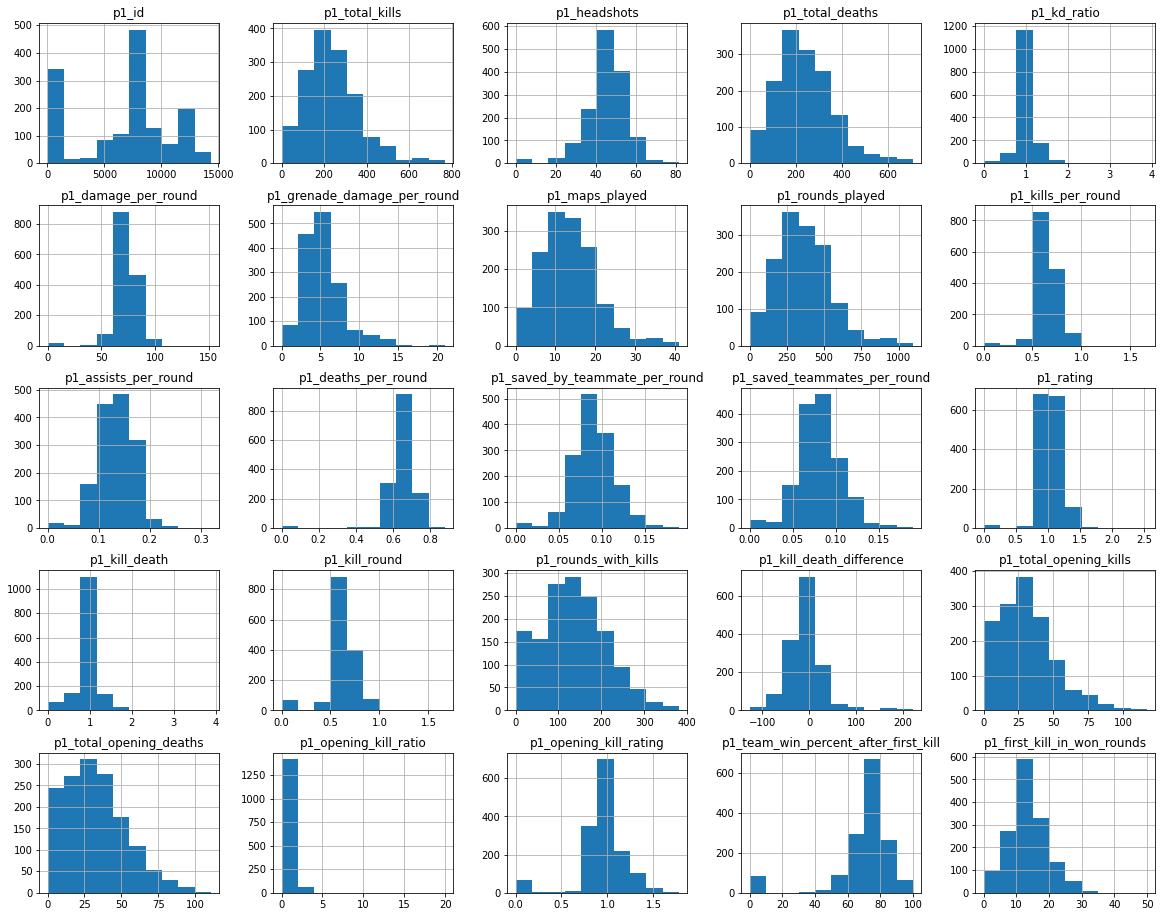

In [31]:
p1_info[p1_cols[:-3]].hist(figsize=(20,16))

много признаков имеют смещение

# Сметчим данные по играм

In [64]:
df = data.copy()

In [65]:
df.head()

,map_id,team1_id,team2_id,map_name,who_win,sample
0,289,6665,7718,Ancient,0.0,1
1,715,4411,10577,Inferno,0.0,1
2,157,11251,9455,Nuke,1.0,1
3,524,4608,7532,Mirage,0.0,1
4,404,8637,6667,Overpass,1.0,1


In [66]:
# добавим столбцы для заполнения
for t in ['team1', 'team2']:
    for col in player_cols[:-3]:
        df[f'{t}_{col}'] = 0

In [67]:
for i in range(len(df)):
    # заполним данные по 1-й команде
    df.iloc[i,6:131] = np.array(players[(players['map_id'] == df['map_id'][i]) & (players['team_id'] == df['team1_id'][i])][player_cols[:-3]])[0]
    # заполним данные по 2-й команде
    df.iloc[i,131:256] = np.array(players[(players['map_id'] == df['map_id'][i]) & (players['team_id'] == df['team2_id'][i])][player_cols[:-3]])[0]

In [68]:
df.head()

,map_id,team1_id,team2_id,map_name,who_win,sample,team1_p1_id,team1_p1_total_kills,team1_p1_headshots,team1_p1_total_deaths,team1_p1_kd_ratio,team1_p1_damage_per_round,team1_p1_grenade_damage_per_round,team1_p1_maps_played,team1_p1_rounds_played,team1_p1_kills_per_round,team1_p1_assists_per_round,team1_p1_deaths_per_round,team1_p1_saved_by_teammate_per_round,team1_p1_saved_teammates_per_round,team1_p1_rating,team1_p1_kill_death,team1_p1_kill_round,team1_p1_rounds_with_kills,team1_p1_kill_death_difference,team1_p1_total_opening_kills,team1_p1_total_opening_deaths,team1_p1_opening_kill_ratio,team1_p1_opening_kill_rating,team1_p1_team_win_percent_after_first_kill,team1_p1_first_kill_in_won_rounds,team1_p2_id,team1_p2_total_kills,team1_p2_headshots,team1_p2_total_deaths,team1_p2_kd_ratio,team1_p2_damage_per_round,team1_p2_grenade_damage_per_round,team1_p2_maps_played,team1_p2_rounds_played,team1_p2_kills_per_round,team1_p2_assists_per_round,team1_p2_deaths_per_round,team1_p2_saved_by_teammate_per_round,team1_p2_saved_teammates_per_round,team1_p2_rating,team1_p2_kill_death,team1_p2_kill_round,team1_p2_rounds_with_kills,team1_p2_kill_death_difference,team1_p2_total_opening_kills,team1_p2_total_opening_deaths,team1_p2_opening_kill_ratio,team1_p2_opening_kill_rating,team1_p2_team_win_percent_after_first_kill,team1_p2_first_kill_in_won_rounds,team1_p3_id,team1_p3_total_kills,team1_p3_headshots,team1_p3_total_deaths,team1_p3_kd_ratio,team1_p3_damage_per_round,team1_p3_grenade_damage_per_round,team1_p3_maps_played,team1_p3_rounds_played,team1_p3_kills_per_round,team1_p3_assists_per_round,team1_p3_deaths_per_round,team1_p3_saved_by_teammate_per_round,team1_p3_saved_teammates_per_round,team1_p3_rating,team1_p3_kill_death,team1_p3_kill_round,team1_p3_rounds_with_kills,team1_p3_kill_death_difference,team1_p3_total_opening_kills,team1_p3_total_opening_deaths,team1_p3_opening_kill_ratio,team1_p3_opening_kill_rating,team1_p3_team_win_percent_after_first_kill,team1_p3_first_kill_in_won_rounds,team1_p4_id,team1_p4_total_kills,team1_p4_headshots,team1_p4_total_deaths,team1_p4_kd_ratio,team1_p4_damage_per_round,team1_p4_grenade_damage_per_round,team1_p4_maps_played,team1_p4_rounds_played,team1_p4_kills_per_round,team1_p4_assists_per_round,team1_p4_deaths_per_round,team1_p4_saved_by_teammate_per_round,team1_p4_saved_teammates_per_round,team1_p4_rating,team1_p4_kill_death,team1_p4_kill_round,team1_p4_rounds_with_kills,team1_p4_kill_death_difference,team1_p4_total_opening_kills,team1_p4_total_opening_deaths,team1_p4_opening_kill_ratio,team1_p4_opening_kill_rating,team1_p4_team_win_percent_after_first_kill,team1_p4_first_kill_in_won_rounds,team1_p5_id,team1_p5_total_kills,team1_p5_headshots,team1_p5_total_deaths,team1_p5_kd_ratio,team1_p5_damage_per_round,team1_p5_grenade_damage_per_round,team1_p5_maps_played,team1_p5_rounds_played,team1_p5_kills_per_round,team1_p5_assists_per_round,team1_p5_deaths_per_round,team1_p5_saved_by_teammate_per_round,team1_p5_saved_teammates_per_round,team1_p5_rating,team1_p5_kill_death,team1_p5_kill_round,team1_p5_rounds_with_kills,team1_p5_kill_death_difference,team1_p5_total_opening_kills,team1_p5_total_opening_deaths,team1_p5_opening_kill_ratio,team1_p5_opening_kill_rating,team1_p5_team_win_percent_after_first_kill,team1_p5_first_kill_in_won_rounds,team2_p1_id,team2_p1_total_kills,team2_p1_headshots,team2_p1_total_deaths,team2_p1_kd_ratio,team2_p1_damage_per_round,team2_p1_grenade_damage_per_round,team2_p1_maps_played,team2_p1_rounds_played,team2_p1_kills_per_round,team2_p1_assists_per_round,team2_p1_deaths_per_round,team2_p1_saved_by_teammate_per_round,team2_p1_saved_teammates_per_round,team2_p1_rating,team2_p1_kill_death,team2_p1_kill_round,team2_p1_rounds_with_kills,team2_p1_kill_death_difference,team2_p1_total_opening_kills,team2_p1_total_opening_deaths,team2_p1_opening_kill_ratio,team2_p1_opening_kill_rating,team2_p1_team_win_percent_after_first_kill,team2_p1_first_kill_in_won_rounds,team2_p2_id,team2_p2_total_kills

In [69]:
df.to_csv('saves/df_1.csv', index=False)

# Feature engineering

cгенерируем признаки:

- shot_damage - урон от выстрелов = урона за раунд - урон гранатой за раунд
- shot_damage_percent - соотношение урона от выстрелов и урона гранатой от общего
- grenade_damage_percent - среднее количество сыгранных раундов в игру
- rounds_with_kill_per_all_rounds - соотношение раундов с убийством ко всем раундам
- kill_death_difference_per_all_plays - соотношение убийств-сметрей / всего игр
- saved_per_saved_by - спасение тиммейта / спасен тиммейтом
- opening_kills_per_death - первых убийств / первых смертей
- rounds_per_games - ср. количество сыгранных раундов за игру
- opening_kills_percent - % первых убийств
- opening_deaths_percent - % первых смертей
- kill_assist_per_death - (ср. убийств + ср. ассистов) / ср.смертей
- kill_assist - ср.убийств + ср.ассистов
- headshot_opening_kill_per_round - 1-х убийств за раунд * % хедшотов
- mean_opening_death_per_death - 1-х смертей за раунд / ср. смертей за раунд
- opening_kill_rating_per_rating - рейтинг 1-х килов / рейтинг
- win_after_first_kill_per_opening_deaths - доля выигранных раундов при 1-м убийстве игрока / ср. 1-х смертей за раунд
- mean_kills_assists - ср(ср.убийств, ср. ассистов)
- KAST - ср. убийств + ср.ассистов + (1-ср.смертей) + ср.спасение тиммейта
- opening_kill_rating_mtp_opening_kills_perc - рейтинг 1-х убийств * % первых убийств
- opening_kill_rating_mtp_opening_death_perc - рейтинг 1-х убийств * % первых смертей
- opening_kills_per_mean_kills - 1-х убийств / ср. убийств за раунд
- headshot_damage - урон от выстрелов за раунд * хедшоты %
- opening_hedshot_kills - % первых убийств * хедшоты %
- mean_headshot_kills_per_round - ср. убийств за раунд * хедшоты %
- total_win_rounds_with_opening_kills - всего раундов * доля выигранных раундов при 1-м убийстве игрока
- mean_damage_per_kills - ср.дамагза раунд / ср.убийств за раунд

In [70]:
for team in ['team1', 'team2']:
    for i in range(1, 6):
        df[f'{team}_p{i}_shot_damage'] = df[f'{team}_p{i}_damage_per_round'] - df[f'{team}_p{i}_grenade_damage_per_round']
        df[f'{team}_p{i}_shot_damage_percent'] = df[f'{team}_p{i}_shot_damage'] / df[f'{team}_p{i}_damage_per_round']
        df[f'{team}_p{i}_grenade_damage_percent'] = df[f'{team}_p{i}_grenade_damage_per_round'] / df[f'{team}_p{i}_damage_per_round']
        df[f'{team}_p{i}_rounds_with_kill_per_all_rounds'] = df[f'{team}_p{i}_rounds_with_kills'] / df[f'{team}_p{i}_rounds_played']
        df[f'{team}_p{i}_kill_death_difference_per_all_plays'] = df[f'{team}_p{i}_kill_death_difference'] / df[f'{team}_p{i}_maps_played']
        df[f'{team}_p{i}_saved_per_saved_by'] = df[f'{team}_p{i}_saved_teammates_per_round'] / df[f'{team}_p{i}_saved_by_teammate_per_round']
        df[f'{team}_p{i}_opening_kills_per_death'] = df[f'{team}_p{i}_total_opening_kills'] / df[f'{team}_p{i}_total_opening_deaths']
        df[f'{team}_p{i}_rounds_per_games'] = df[f'{team}_p{i}_rounds_played'] / df[f'{team}_p{i}_maps_played']
        df[f'{team}_p{i}_opening_kills_percent'] = df[f'{team}_p{i}_total_opening_kills'] / df[f'{team}_p{i}_rounds_played']
        df[f'{team}_p{i}_opening_deaths_percent'] = df[f'{team}_p{i}_total_opening_deaths'] / df[f'{team}_p{i}_rounds_played']
        df[f'{team}_p{i}_kill_assist_per_death'] = (df[f'{team}_p{i}_kills_per_round'] + df[f'{team}_p{i}_assists_per_round']) / df[f'{team}_p{i}_deaths_per_round']
        df[f'{team}_p{i}_kill_assist'] = df[f'{team}_p{i}_kills_per_round'] + df[f'{team}_p{i}_assists_per_round']
        df[f'{team}_p{i}_headshot_opening_kill_per_round'] = df[f'{team}_p{i}_opening_kills_percent'] * df[f'{team}_p{i}_headshots']
        df[f'{team}_p{i}_mean_opening_death_per_death'] = df[f'{team}_p{i}_opening_deaths_percent'] / df[f'{team}_p{i}_deaths_per_round']
        df[f'{team}_p{i}_opening_kill_rating_per_rating'] = df[f'{team}_p{i}_opening_kill_rating'] / df[f'{team}_p{i}_rating']
        df[f'{team}_p{i}_win_after_first_kill_per_opening_deaths'] = df[f'{team}_p{i}_team_win_percent_after_first_kill'] / df[f'{team}_p{i}_opening_deaths_percent']
        df[f'{team}_p{i}_mean_kills_assists'] = (df[f'{team}_p{i}_kills_per_round'] + df[f'{team}_p{i}_assists_per_round']) / 2
        df[f'{team}_p{i}_kast'] = df[f'{team}_p{i}_kills_per_round'] + df[f'{team}_p{i}_assists_per_round'] + (1 - df[f'{team}_p{i}_deaths_per_round']) + df[f'{team}_p{i}_saved_teammates_per_round']
        df[f'{team}_p{i}_opening_kill_rating_mtp_opening_kills_perc'] = df[f'{team}_p{i}_opening_kill_rating'] * df[f'{team}_p{i}_opening_kills_percent']
        df[f'{team}_p{i}_opening_kill_rating_mtp_opening_death_perc'] = df[f'{team}_p{i}_opening_kill_rating'] * df[f'{team}_p{i}_opening_deaths_percent']
        df[f'{team}_p{i}_opening_kills_per_mean_kills'] = df[f'{team}_p{i}_opening_kills_percent'] / df[f'{team}_p{i}_kills_per_round']
        df[f'{team}_p{i}_headshot_damage'] = df[f'{team}_p{i}_shot_damage'] * df[f'{team}_p{i}_headshots']
        df[f'{team}_p{i}_opening_hedshot_kills'] = df[f'{team}_p{i}_opening_kills_percent'] * df[f'{team}_p{i}_headshots']
        df[f'{team}_p{i}_mean_headshot_kills_per_round'] = df[f'{team}_p{i}_kills_per_round'] * df[f'{team}_p{i}_headshots']
        df[f'{team}_p{i}_total_win_rounds_with_opening_kills'] = df[f'{team}_p{i}_rounds_played'] * df[f'{team}_p{i}_team_win_percent_after_first_kill']
        df[f'{team}_p{i}_mean_damage_per_kills'] = df[f'{team}_p{i}_damage_per_round'] / df[f'{team}_p{i}_kills_per_round']

**проработаем пропуски и бесконечные значения в новых признаках**

In [71]:
df.tail(10)

,map_id,team1_id,team2_id,map_name,who_win,sample,team1_p1_id,team1_p1_total_kills,team1_p1_headshots,team1_p1_total_deaths,team1_p1_kd_ratio,team1_p1_damage_per_round,team1_p1_grenade_damage_per_round,team1_p1_maps_played,team1_p1_rounds_played,team1_p1_kills_per_round,team1_p1_assists_per_round,team1_p1_deaths_per_round,team1_p1_saved_by_teammate_per_round,team1_p1_saved_teammates_per_round,team1_p1_rating,team1_p1_kill_death,team1_p1_kill_round,team1_p1_rounds_with_kills,team1_p1_kill_death_difference,team1_p1_total_opening_kills,team1_p1_total_opening_deaths,team1_p1_opening_kill_ratio,team1_p1_opening_kill_rating,team1_p1_team_win_percent_after_first_kill,team1_p1_first_kill_in_won_rounds,team1_p2_id,team1_p2_total_kills,team1_p2_headshots,team1_p2_total_deaths,team1_p2_kd_ratio,team1_p2_damage_per_round,team1_p2_grenade_damage_per_round,team1_p2_maps_played,team1_p2_rounds_played,team1_p2_kills_per_round,team1_p2_assists_per_round,team1_p2_deaths_per_round,team1_p2_saved_by_teammate_per_round,team1_p2_saved_teammates_per_round,team1_p2_rating,team1_p2_kill_death,team1_p2_kill_round,team1_p2_rounds_with_kills,team1_p2_kill_death_difference,team1_p2_total_opening_kills,team1_p2_total_opening_deaths,team1_p2_opening_kill_ratio,team1_p2_opening_kill_rating,team1_p2_team_win_percent_after_first_kill,team1_p2_first_kill_in_won_rounds,team1_p3_id,team1_p3_total_kills,team1_p3_headshots,team1_p3_total_deaths,team1_p3_kd_ratio,team1_p3_damage_per_round,team1_p3_grenade_damage_per_round,team1_p3_maps_played,team1_p3_rounds_played,team1_p3_kills_per_round,team1_p3_assists_per_round,team1_p3_deaths_per_round,team1_p3_saved_by_teammate_per_round,team1_p3_saved_teammates_per_round,team1_p3_rating,team1_p3_kill_death,team1_p3_kill_round,team1_p3_rounds_with_kills,team1_p3_kill_death_difference,team1_p3_total_opening_kills,team1_p3_total_opening_deaths,team1_p3_opening_kill_ratio,team1_p3_opening_kill_rating,team1_p3_team_win_percent_after_first_kill,team1_p3_first_kill_in_won_rounds,team1_p4_id,team1_p4_total_kills,team1_p4_headshots,team1_p4_total_deaths,team1_p4_kd_ratio,team1_p4_damage_per_round,team1_p4_grenade_damage_per_round,team1_p4_maps_played,team1_p4_rounds_played,team1_p4_kills_per_round,team1_p4_assists_per_round,team1_p4_deaths_per_round,team1_p4_saved_by_teammate_per_round,team1_p4_saved_teammates_per_round,team1_p4_rating,team1_p4_kill_death,team1_p4_kill_round,team1_p4_rounds_with_kills,team1_p4_kill_death_difference,team1_p4_total_opening_kills,team1_p4_total_opening_deaths,team1_p4_opening_kill_ratio,team1_p4_opening_kill_rating,team1_p4_team_win_percent_after_first_kill,team1_p4_first_kill_in_won_rounds,team1_p5_id,team1_p5_total_kills,team1_p5_headshots,team1_p5_total_deaths,team1_p5_kd_ratio,team1_p5_damage_per_round,team1_p5_grenade_damage_per_round,team1_p5_maps_played,team1_p5_rounds_played,team1_p5_kills_per_round,team1_p5_assists_per_round,team1_p5_deaths_per_round,team1_p5_saved_by_teammate_per_round,team1_p5_saved_teammates_per_round,team1_p5_rating,team1_p5_kill_death,team1_p5_kill_round,team1_p5_rounds_with_kills,team1_p5_kill_death_difference,team1_p5_total_opening_kills,team1_p5_total_opening_deaths,team1_p5_opening_kill_ratio,team1_p5_opening_kill_rating,team1_p5_team_win_percent_after_first_kill,team1_p5_first_kill_in_won_rounds,team2_p1_id,team2_p1_total_kills,team2_p1_headshots,team2_p1_total_deaths,team2_p1_kd_ratio,team2_p1_damage_per_round,team2_p1_grenade_damage_per_round,team2_p1_maps_played,team2_p1_rounds_played,team2_p1_kills_per_round,team2_p1_assists_per_round,team2_p1_deaths_per_round,team2_p1_saved_by_teammate_per_round,team2_p1_saved_teammates_per_round,team2_p1_rating,team2_p1_kill_death,team2_p1_kill_round,team2_p1_rounds_with_kills,team2_p1_kill_death_difference,team2_p1_total_opening_kills,team2_p1_total_opening_deaths,team2_p1_opening_kill_ratio,team2_p1_opening_kill_rating,team2_p1_team_win_percent_after_first_kill,team2_p1_first_kill_in_won_rounds,team2_p2_id,team2_p2_total_kills

In [72]:
# все пропуски связаны с отсутствием игр у игрока на карте, установим 0 для пропусков
# также пропуски на 'who_win' для тестовых данных
df.fillna(0, inplace=True)

In [73]:
# при делении на 0
df.replace([-np.inf, np.inf], [0, 1], inplace=True)

**anova score - оценим пользу признаков**

рассмотрю для 1-х игроков, т.к. слишком много признаков

In [74]:
player_cols_new = df.columns
p1_cols_new = [x for x in player_cols_new if 'team1_p1' in x]

In [75]:
# оставим только тренировочные данные для анализа
train_df = df[df['sample'] == 1]

<AxesSubplot:>

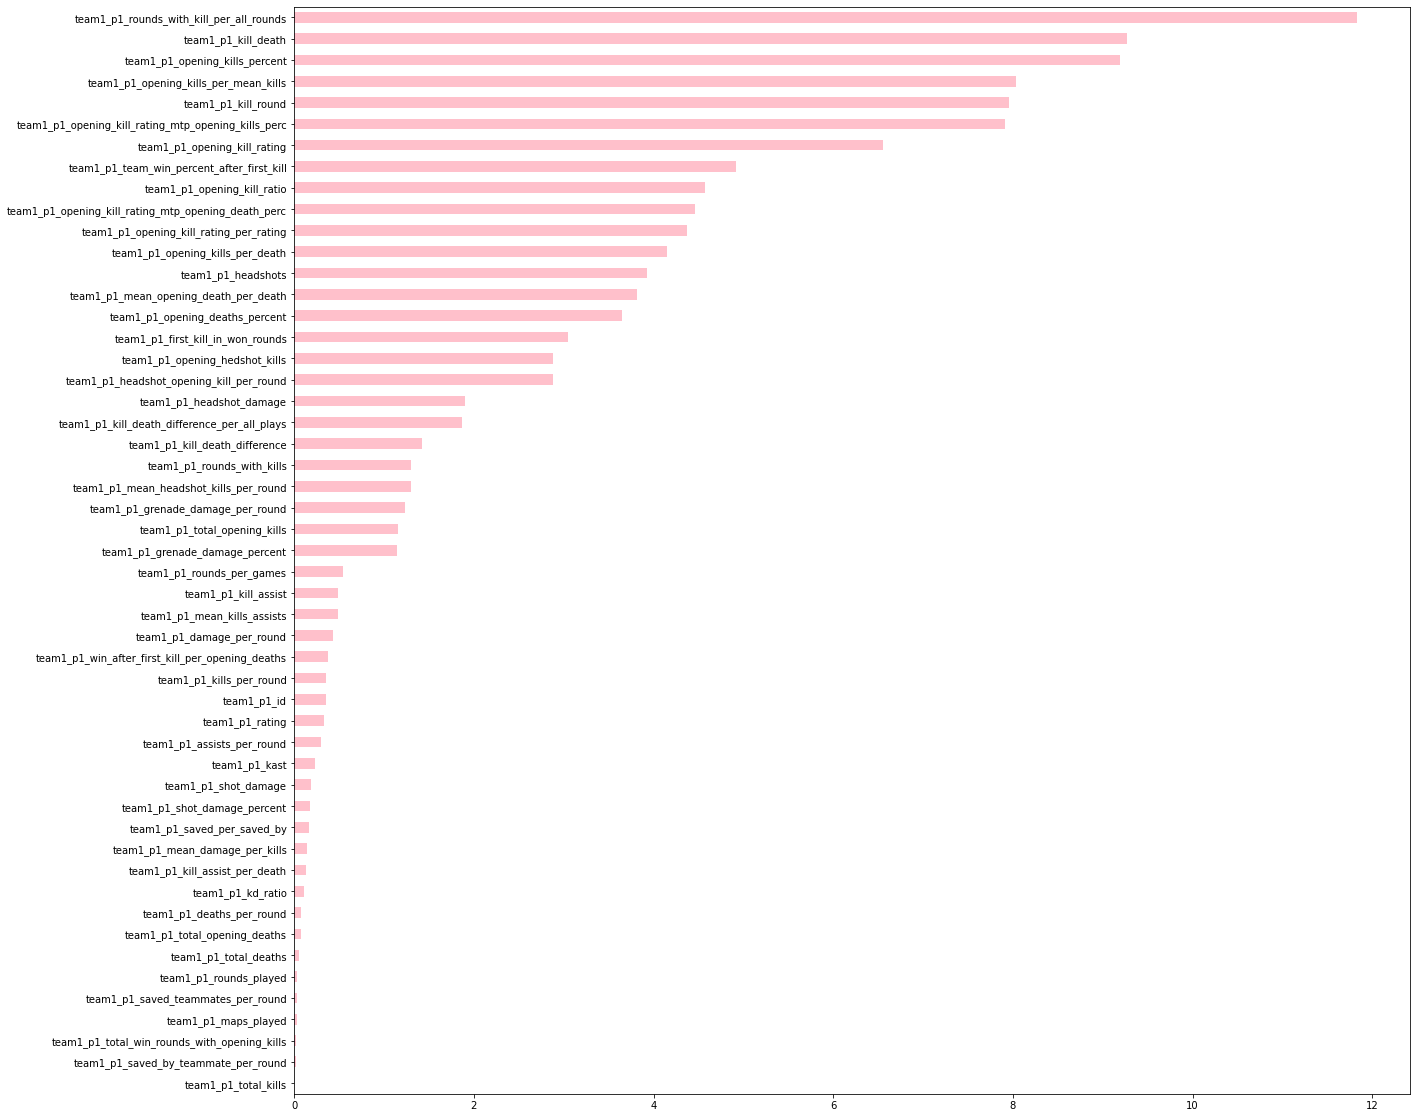

In [80]:
imp_num = pd.Series(f_classif(train_df[p1_cols_new], train_df['who_win'])[0], index = p1_cols_new)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color='pink', figsize=(20,20))

Удалим наименее полезные признаки:

- team1_p1_total_kills                                   4.185057e-10
- team1_p1_team_win_percent_after_first_kill             1.779749e-02
- team1_p1_saved_by_teammate_per_round                   2.241474e-02
- team1_p1_maps_played                                   2.879117e-02
- team1_p1_saved_teammates_per_round                     3.294126e-02
- team1_p1_rounds_played                                 3.446220e-02
- team1_p1_total_deaths                                  5.193605e-02
- team1_p1_total_win_rounds_with_opening_kills           6.500510e-02
- team1_p1_deaths_per_round                              7.396894e-02
- id - не несет реальной пользы (случайность)

In [81]:
del_feat = ['total_kills', 'team_win_percent_after_first_kill', 'saved_by_teammate_per_round',
           'maps_played', 'saved_teammates_per_round', 'rounds_played', 'total_deaths', 'total_win_rounds_with_opening_kills',
           'deaths_per_round', 'id']

In [82]:
for team in ['team1', 'team2']:
    for i in range(1, 6):
        for feat in del_feat:
            del df[f'{team}_p{i}_{feat}']
            del train_df[f'{team}_p{i}_{feat}']

In [83]:
# проверим корректность удаления столбцов
len(train_df.columns)

416

**Корреляции между признаками**

Также рассмотрю только для 1-х игроков

In [84]:
player_cols_new = train_df.columns
p1_cols_new = [x for x in player_cols_new if 'team1_p1' in x]

<AxesSubplot:>

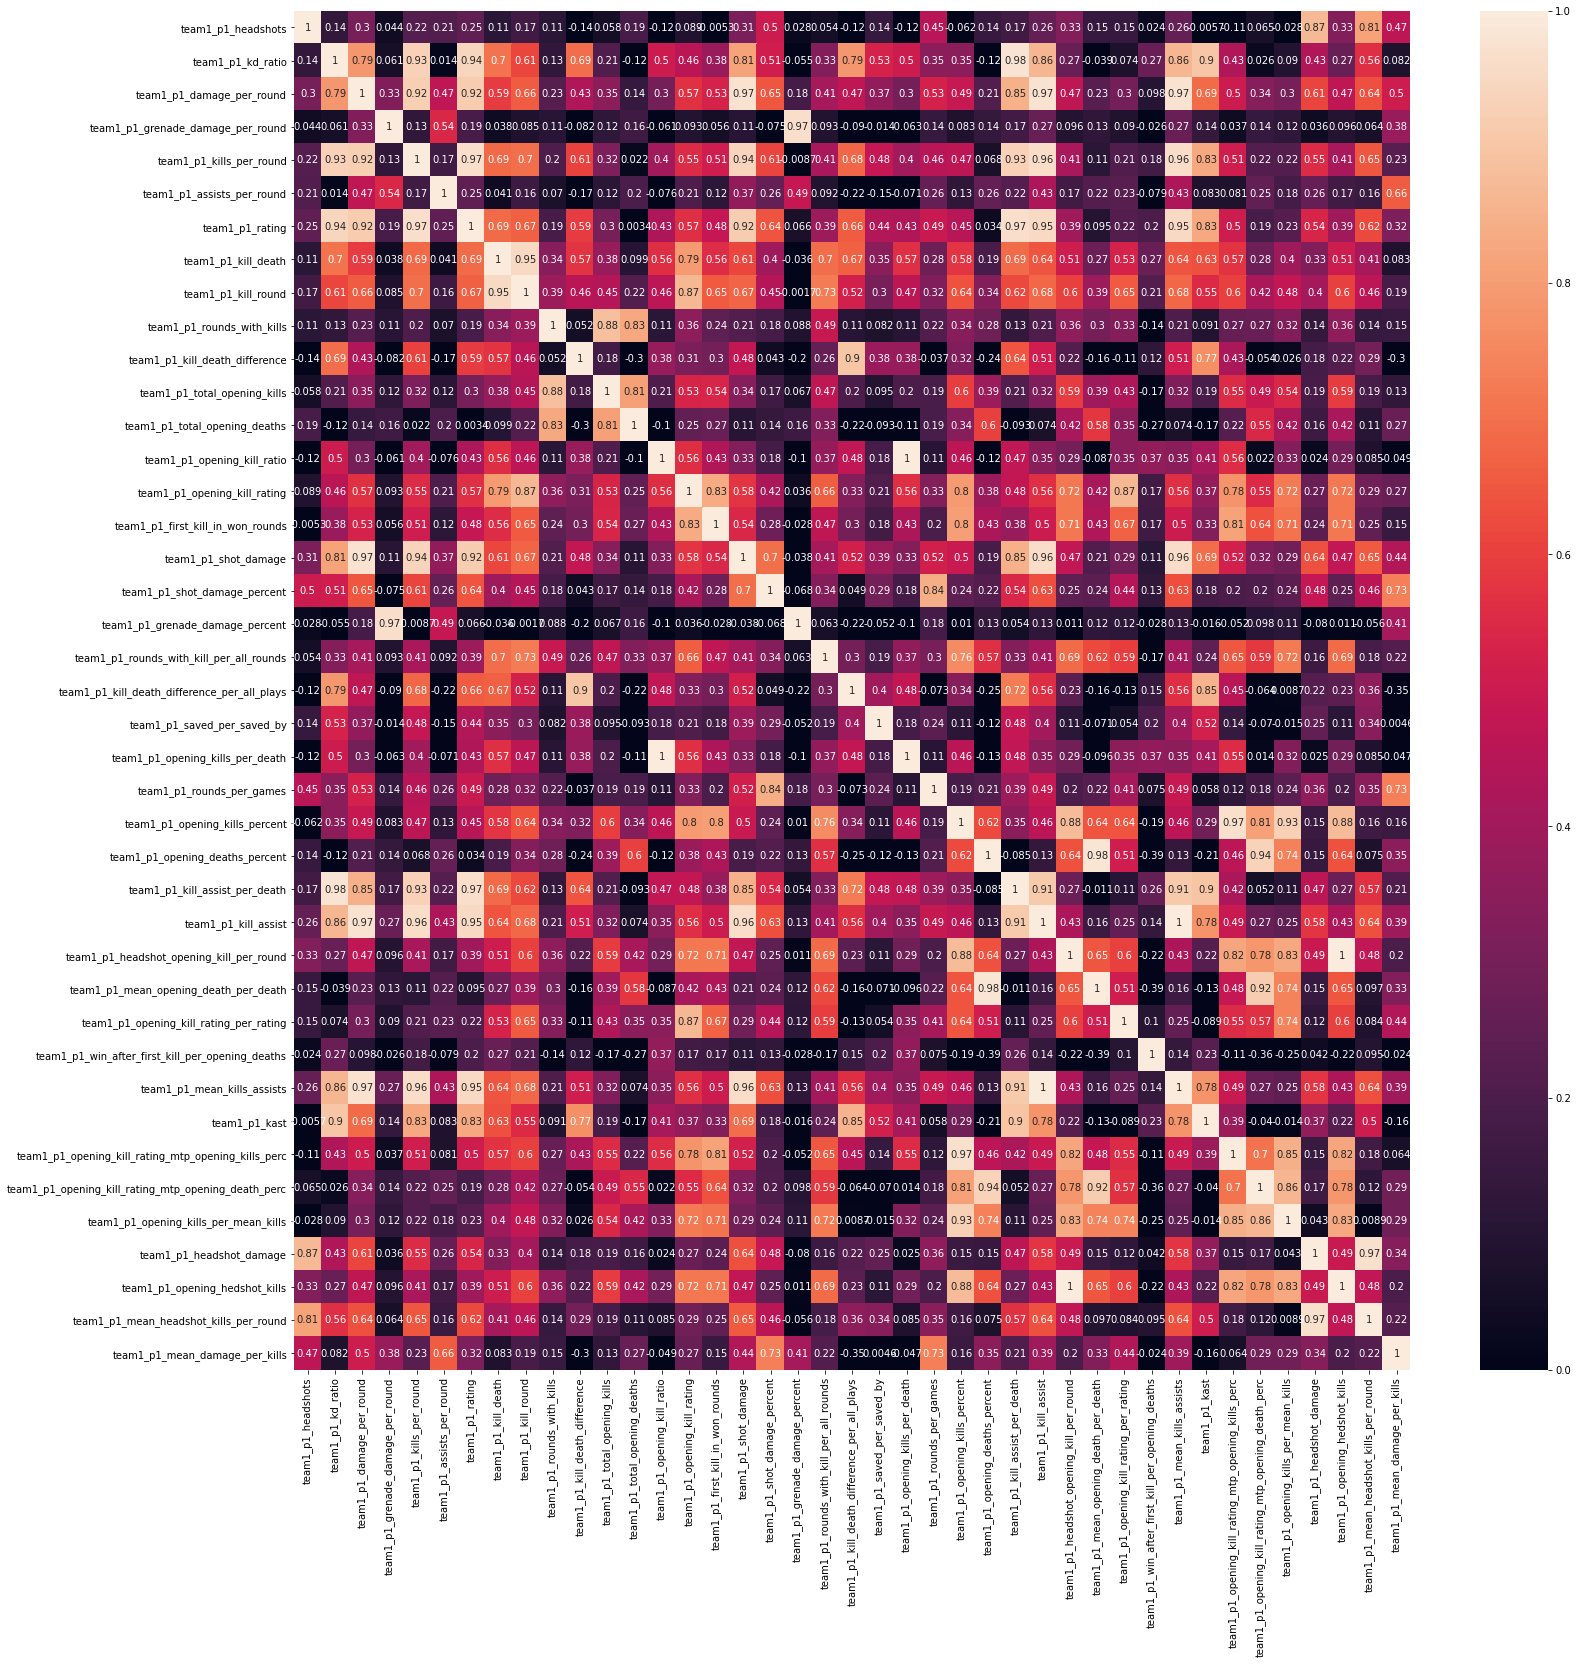

In [85]:
plt.rcParams['figure.figsize'] = (25,25)
sns.heatmap(train_df[p1_cols_new].corr(), vmin=0, vmax=1, annot = True)

Претенденты на удаление (при высокой корреляции (>= 0.9) и полезности ниже коррелируемого):

- headshot_damage (выскоий annova)
- mean_headshot_kills_per_round (выскоий annova)
- kd_ratio
- kills_per_round
- rating
- kill_round
- rounds_with_kills
- shot_damage
- damage_per_round
- grenade_damage_percent
- kill_death
- opening_kills_per_death 
- kast
- opening_kills_percent (выскоий annova)
- opening_deaths_percent (выскоий annova)
- kill_assist_per_death
- mean_kills_assists
- headshot_opening_kill_per_round (выскоий annova)
- opening_kill_rating_mtp_opening_death_perc (выскоий annova)
- opening_hedshot_kills (выскоий annova)

Данные имеют крайне высокую корреляцию и требуют более детального изучения

Сохраним данные с высоким показателем anova, т.к. положительно влияет на результат, несмотря на высокую корреляцию

In [86]:
del_feat2_min = ['kd_ratio', 'kills_per_round', 'rating',
            'kill_round', 'rounds_with_kills', 'shot_damage', 'damage_per_round', 'grenade_damage_percent',
            'kill_death', 'opening_kills_per_death', 'kast',
            'kill_assist_per_death', 'mean_kills_assists']

In [87]:
for team in ['team1', 'team2']:
    for i in range(1, 6):
        for feat in del_feat2_min:
            del train_df[f'{team}_p{i}_{feat}']
            del df[f'{team}_p{i}_{feat}']

In [88]:
df.tail(10)

,map_id,team1_id,team2_id,map_name,who_win,sample,team1_p1_headshots,team1_p1_grenade_damage_per_round,team1_p1_assists_per_round,team1_p1_kill_death_difference,team1_p1_total_opening_kills,team1_p1_total_opening_deaths,team1_p1_opening_kill_ratio,team1_p1_opening_kill_rating,team1_p1_first_kill_in_won_rounds,team1_p2_headshots,team1_p2_grenade_damage_per_round,team1_p2_assists_per_round,team1_p2_kill_death_difference,team1_p2_total_opening_kills,team1_p2_total_opening_deaths,team1_p2_opening_kill_ratio,team1_p2_opening_kill_rating,team1_p2_first_kill_in_won_rounds,team1_p3_headshots,team1_p3_grenade_damage_per_round,team1_p3_assists_per_round,team1_p3_kill_death_difference,team1_p3_total_opening_kills,team1_p3_total_opening_deaths,team1_p3_opening_kill_ratio,team1_p3_opening_kill_rating,team1_p3_first_kill_in_won_rounds,team1_p4_headshots,team1_p4_grenade_damage_per_round,team1_p4_assists_per_round,team1_p4_kill_death_difference,team1_p4_total_opening_kills,team1_p4_total_opening_deaths,team1_p4_opening_kill_ratio,team1_p4_opening_kill_rating,team1_p4_first_kill_in_won_rounds,team1_p5_headshots,team1_p5_grenade_damage_per_round,team1_p5_assists_per_round,team1_p5_kill_death_difference,team1_p5_total_opening_kills,team1_p5_total_opening_deaths,team1_p5_opening_kill_ratio,team1_p5_opening_kill_rating,team1_p5_first_kill_in_won_rounds,team2_p1_headshots,team2_p1_grenade_damage_per_round,team2_p1_assists_per_round,team2_p1_kill_death_difference,team2_p1_total_opening_kills,team2_p1_total_opening_deaths,team2_p1_opening_kill_ratio,team2_p1_opening_kill_rating,team2_p1_first_kill_in_won_rounds,team2_p2_headshots,team2_p2_grenade_damage_per_round,team2_p2_assists_per_round,team2_p2_kill_death_difference,team2_p2_total_opening_kills,team2_p2_total_opening_deaths,team2_p2_opening_kill_ratio,team2_p2_opening_kill_rating,team2_p2_first_kill_in_won_rounds,team2_p3_headshots,team2_p3_grenade_damage_per_round,team2_p3_assists_per_round,team2_p3_kill_death_difference,team2_p3_total_opening_kills,team2_p3_total_opening_deaths,team2_p3_opening_kill_ratio,team2_p3_opening_kill_rating,team2_p3_first_kill_in_won_rounds,team2_p4_headshots,team2_p4_grenade_damage_per_round,team2_p4_assists_per_round,team2_p4_kill_death_difference,team2_p4_total_opening_kills,team2_p4_total_opening_deaths,team2_p4_opening_kill_ratio,team2_p4_opening_kill_rating,team2_p4_first_kill_in_won_rounds,team2_p5_headshots,team2_p5_grenade_damage_per_round,team2_p5_assists_per_round,team2_p5_kill_death_difference,team2_p5_total_opening_kills,team2_p5_total_opening_deaths,team2_p5_opening_kill_ratio,team2_p5_opening_kill_rating,team2_p5_first_kill_in_won_rounds,team1_p1_shot_damage_percent,team1_p1_rounds_with_kill_per_all_rounds,team1_p1_kill_death_difference_per_all_plays,team1_p1_saved_per_saved_by,team1_p1_rounds_per_games,team1_p1_opening_kills_percent,team1_p1_opening_deaths_percent,team1_p1_kill_assist,team1_p1_headshot_opening_kill_per_round,team1_p1_mean_opening_death_per_death,team1_p1_opening_kill_rating_per_rating,team1_p1_win_after_first_kill_per_opening_deaths,team1_p1_opening_kill_rating_mtp_opening_kills_perc,team1_p1_opening_kill_rating_mtp_opening_death_perc,team1_p1_opening_kills_per_mean_kills,team1_p1_headshot_damage,team1_p1_opening_hedshot_kills,team1_p1_mean_headshot_kills_per_round,team1_p1_mean_damage_per_kills,team1_p2_shot_damage_percent,team1_p2_rounds_with_kill_per_all_rounds,team1_p2_kill_death_difference_per_all_plays,team1_p2_saved_per_saved_by,team1_p2_rounds_per_games,team1_p2_opening_kills_percent,team1_p2_opening_deaths_percent,team1_p2_kill_assist,team1_p2_headshot_opening_kill_per_round,team1_p2_mean_opening_death_per_death,team1_p2_opening_kill_rating_per_rating,team1_p2_win_after_first_kill_per_opening_deaths,team1_p2_opening_kill_rating_mtp_opening_kills_perc,team1_p2_opening_kill_rating_mtp_opening_death_perc,team1_p2_opening_kills_per_mean_kills,team1_p2_headshot_damage,team1_p2_opening_hedshot_kills,team1_p2_mean_headshot_kills_per

In [89]:
df.to_csv('saves/df_2.csv', index=False)

# Подготовим данные на вход модели

In [373]:
df = pd.read_csv('saves/df_2.csv')

In [374]:
df.tail(5)

,map_id,team1_id,team2_id,map_name,who_win,sample,team1_p1_headshots,team1_p1_grenade_damage_per_round,team1_p1_assists_per_round,team1_p1_kill_death_difference,team1_p1_total_opening_kills,team1_p1_total_opening_deaths,team1_p1_opening_kill_ratio,team1_p1_opening_kill_rating,team1_p1_first_kill_in_won_rounds,team1_p2_headshots,team1_p2_grenade_damage_per_round,team1_p2_assists_per_round,team1_p2_kill_death_difference,team1_p2_total_opening_kills,team1_p2_total_opening_deaths,team1_p2_opening_kill_ratio,team1_p2_opening_kill_rating,team1_p2_first_kill_in_won_rounds,team1_p3_headshots,team1_p3_grenade_damage_per_round,team1_p3_assists_per_round,team1_p3_kill_death_difference,team1_p3_total_opening_kills,team1_p3_total_opening_deaths,team1_p3_opening_kill_ratio,team1_p3_opening_kill_rating,team1_p3_first_kill_in_won_rounds,team1_p4_headshots,team1_p4_grenade_damage_per_round,team1_p4_assists_per_round,team1_p4_kill_death_difference,team1_p4_total_opening_kills,team1_p4_total_opening_deaths,team1_p4_opening_kill_ratio,team1_p4_opening_kill_rating,team1_p4_first_kill_in_won_rounds,team1_p5_headshots,team1_p5_grenade_damage_per_round,team1_p5_assists_per_round,team1_p5_kill_death_difference,team1_p5_total_opening_kills,team1_p5_total_opening_deaths,team1_p5_opening_kill_ratio,team1_p5_opening_kill_rating,team1_p5_first_kill_in_won_rounds,team2_p1_headshots,team2_p1_grenade_damage_per_round,team2_p1_assists_per_round,team2_p1_kill_death_difference,team2_p1_total_opening_kills,team2_p1_total_opening_deaths,team2_p1_opening_kill_ratio,team2_p1_opening_kill_rating,team2_p1_first_kill_in_won_rounds,team2_p2_headshots,team2_p2_grenade_damage_per_round,team2_p2_assists_per_round,team2_p2_kill_death_difference,team2_p2_total_opening_kills,team2_p2_total_opening_deaths,team2_p2_opening_kill_ratio,team2_p2_opening_kill_rating,team2_p2_first_kill_in_won_rounds,team2_p3_headshots,team2_p3_grenade_damage_per_round,team2_p3_assists_per_round,team2_p3_kill_death_difference,team2_p3_total_opening_kills,team2_p3_total_opening_deaths,team2_p3_opening_kill_ratio,team2_p3_opening_kill_rating,team2_p3_first_kill_in_won_rounds,team2_p4_headshots,team2_p4_grenade_damage_per_round,team2_p4_assists_per_round,team2_p4_kill_death_difference,team2_p4_total_opening_kills,team2_p4_total_opening_deaths,team2_p4_opening_kill_ratio,team2_p4_opening_kill_rating,team2_p4_first_kill_in_won_rounds,team2_p5_headshots,team2_p5_grenade_damage_per_round,team2_p5_assists_per_round,team2_p5_kill_death_difference,team2_p5_total_opening_kills,team2_p5_total_opening_deaths,team2_p5_opening_kill_ratio,team2_p5_opening_kill_rating,team2_p5_first_kill_in_won_rounds,team1_p1_shot_damage_percent,team1_p1_rounds_with_kill_per_all_rounds,team1_p1_kill_death_difference_per_all_plays,team1_p1_saved_per_saved_by,team1_p1_rounds_per_games,team1_p1_opening_kills_percent,team1_p1_opening_deaths_percent,team1_p1_kill_assist,team1_p1_headshot_opening_kill_per_round,team1_p1_mean_opening_death_per_death,team1_p1_opening_kill_rating_per_rating,team1_p1_win_after_first_kill_per_opening_deaths,team1_p1_opening_kill_rating_mtp_opening_kills_perc,team1_p1_opening_kill_rating_mtp_opening_death_perc,team1_p1_opening_kills_per_mean_kills,team1_p1_headshot_damage,team1_p1_opening_hedshot_kills,team1_p1_mean_headshot_kills_per_round,team1_p1_mean_damage_per_kills,team1_p2_shot_damage_percent,team1_p2_rounds_with_kill_per_all_rounds,team1_p2_kill_death_difference_per_all_plays,team1_p2_saved_per_saved_by,team1_p2_rounds_per_games,team1_p2_opening_kills_percent,team1_p2_opening_deaths_percent,team1_p2_kill_assist,team1_p2_headshot_opening_kill_per_round,team1_p2_mean_opening_death_per_death,team1_p2_opening_kill_rating_per_rating,team1_p2_win_after_first_kill_per_opening_deaths,team1_p2_opening_kill_rating_mtp_opening_kills_perc,team1_p2_opening_kill_rating_mtp_opening_death_perc,team1_p2_opening_kills_per_mean_kills,team1_p2_headshot_damage,team1_p2_opening_hedshot_kills,team1_p2_mean_headshot_kills_per

In [375]:
df.describe()

,map_id,team1_id,team2_id,who_win,sample,team1_p1_headshots,team1_p1_grenade_damage_per_round,team1_p1_assists_per_round,team1_p1_kill_death_difference,team1_p1_total_opening_kills,team1_p1_total_opening_deaths,team1_p1_opening_kill_ratio,team1_p1_opening_kill_rating,team1_p1_first_kill_in_won_rounds,team1_p2_headshots,team1_p2_grenade_damage_per_round,team1_p2_assists_per_round,team1_p2_kill_death_difference,team1_p2_total_opening_kills,team1_p2_total_opening_deaths,team1_p2_opening_kill_ratio,team1_p2_opening_kill_rating,team1_p2_first_kill_in_won_rounds,team1_p3_headshots,team1_p3_grenade_damage_per_round,team1_p3_assists_per_round,team1_p3_kill_death_difference,team1_p3_total_opening_kills,team1_p3_total_opening_deaths,team1_p3_opening_kill_ratio,team1_p3_opening_kill_rating,team1_p3_first_kill_in_won_rounds,team1_p4_headshots,team1_p4_grenade_damage_per_round,team1_p4_assists_per_round,team1_p4_kill_death_difference,team1_p4_total_opening_kills,team1_p4_total_opening_deaths,team1_p4_opening_kill_ratio,team1_p4_opening_kill_rating,team1_p4_first_kill_in_won_rounds,team1_p5_headshots,team1_p5_grenade_damage_per_round,team1_p5_assists_per_round,team1_p5_kill_death_difference,team1_p5_total_opening_kills,team1_p5_total_opening_deaths,team1_p5_opening_kill_ratio,team1_p5_opening_kill_rating,team1_p5_first_kill_in_won_rounds,team2_p1_headshots,team2_p1_grenade_damage_per_round,team2_p1_assists_per_round,team2_p1_kill_death_difference,team2_p1_total_opening_kills,team2_p1_total_opening_deaths,team2_p1_opening_kill_ratio,team2_p1_opening_kill_rating,team2_p1_first_kill_in_won_rounds,team2_p2_headshots,team2_p2_grenade_damage_per_round,team2_p2_assists_per_round,team2_p2_kill_death_difference,team2_p2_total_opening_kills,team2_p2_total_opening_deaths,team2_p2_opening_kill_ratio,team2_p2_opening_kill_rating,team2_p2_first_kill_in_won_rounds,team2_p3_headshots,team2_p3_grenade_damage_per_round,team2_p3_assists_per_round,team2_p3_kill_death_difference,team2_p3_total_opening_kills,team2_p3_total_opening_deaths,team2_p3_opening_kill_ratio,team2_p3_opening_kill_rating,team2_p3_first_kill_in_won_rounds,team2_p4_headshots,team2_p4_grenade_damage_per_round,team2_p4_assists_per_round,team2_p4_kill_death_difference,team2_p4_total_opening_kills,team2_p4_total_opening_deaths,team2_p4_opening_kill_ratio,team2_p4_opening_kill_rating,team2_p4_first_kill_in_won_rounds,team2_p5_headshots,team2_p5_grenade_damage_per_round,team2_p5_assists_per_round,team2_p5_kill_death_difference,team2_p5_total_opening_kills,team2_p5_total_opening_deaths,team2_p5_opening_kill_ratio,team2_p5_opening_kill_rating,team2_p5_first_kill_in_won_rounds,team1_p1_shot_damage_percent,team1_p1_rounds_with_kill_per_all_rounds,team1_p1_kill_death_difference_per_all_plays,team1_p1_saved_per_saved_by,team1_p1_rounds_per_games,team1_p1_opening_kills_percent,team1_p1_opening_deaths_percent,team1_p1_kill_assist,team1_p1_headshot_opening_kill_per_round,team1_p1_mean_opening_death_per_death,team1_p1_opening_kill_rating_per_rating,team1_p1_win_after_first_kill_per_opening_deaths,team1_p1_opening_kill_rating_mtp_opening_kills_perc,team1_p1_opening_kill_rating_mtp_opening_death_perc,team1_p1_opening_kills_per_mean_kills,team1_p1_headshot_damage,team1_p1_opening_hedshot_kills,team1_p1_mean_headshot_kills_per_round,team1_p1_mean_damage_per_kills,team1_p2_shot_damage_percent,team1_p2_rounds_with_kill_per_all_rounds,team1_p2_kill_death_difference_per_all_plays,team1_p2_saved_per_saved_by,team1_p2_rounds_per_games,team1_p2_opening_kills_percent,team1_p2_opening_deaths_percent,team1_p2_kill_assist,team1_p2_headshot_opening_kill_per_round,team1_p2_mean_opening_death_per_death,team1_p2_opening_kill_rating_per_rating,team1_p2_win_after_first_kill_per_opening_deaths,team1_p2_opening_kill_rating_mtp_opening_kills_perc,team1_p2_opening_kill_rating_mtp_opening_death_perc,team1_p2_opening_kills_per_mean_kills,team1_p2_headshot_damage,team1_p2_opening_hedshot_kills,team1_p2_mean_headshot_kills_per_round,te

**MinMax нормализация**

Показала лучший прирост на baseline

In [376]:
scaler = MinMaxScaler()

Столбцы с отрицательными значениями:

- kill_death_difference = -127
- kill_death_difference_per_all_plays = -13

In [377]:
# масштабируем признаки с отрицательными значениями в положительные
for team in ['team1', 'team2']:
    for i in range(1, 6):
        df[f'{team}_p{i}_kill_death_difference'] = df[f'{team}_p{i}_kill_death_difference'] + 128
        df[f'{team}_p{i}_kill_death_difference_per_all_plays'] = df[f'{team}_p{i}_kill_death_difference_per_all_plays'] + 13

In [436]:
X = df.drop(['sample', 'who_win', 'map_name', 'map_id', 'team1_id', 'team2_id'], axis=1).values
y = df['who_win'].values # целевой признак

In [437]:
X = scaler.fit_transform(X)

In [438]:
# разделим трейн и тест
X_main = X[:-30]
y = y[:-30]
X_test = X[-30:]

In [439]:
# разобьем трейн на тренировочную и тестовую выборки
X_train, X_valid, y_train, y_valid = train_test_split(X_main, y, test_size=0.1, random_state=RANDOM_SEED)

# Подберем лучший алгоритм ML

**LogisticRegression**

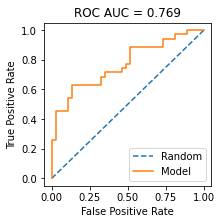

In [440]:
model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
probs = model.predict_proba(X_valid)
roc_auc_create(probs, y_valid)

**SVC**

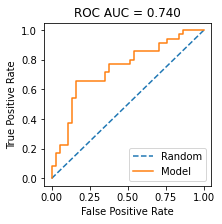

In [441]:
model = SVC(random_state=RANDOM_SEED, probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
probs = model.predict_proba(X_valid)
roc_auc_create(probs, y_valid)

**RandomForestClassifier**

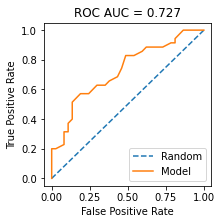

In [442]:
model = RandomForestClassifier(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
probs = model.predict_proba(X_valid)
roc_auc_create(probs, y_valid)

**GradientBoostingClassifier**

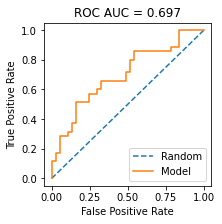

In [443]:
model = GradientBoostingClassifier(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
probs = model.predict_proba(X_valid)
roc_auc_create(probs, y_valid)

**MLPClassifier**

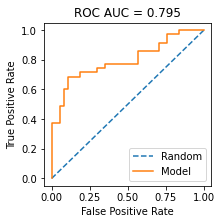

In [444]:
model = MLPClassifier(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
probs = model.predict_proba(X_valid)
roc_auc_create(probs, y_valid)

**catboost**

Learning rate set to 0.00852
0:	learn: 0.6921066	total: 85.1ms	remaining: 1m 25s
1:	learn: 0.6906141	total: 100ms	remaining: 49.9s
2:	learn: 0.6894281	total: 114ms	remaining: 37.8s
3:	learn: 0.6884489	total: 127ms	remaining: 31.6s
4:	learn: 0.6873028	total: 140ms	remaining: 27.9s
5:	learn: 0.6859888	total: 154ms	remaining: 25.5s
6:	learn: 0.6847163	total: 167ms	remaining: 23.7s
7:	learn: 0.6835057	total: 180ms	remaining: 22.3s
8:	learn: 0.6824814	total: 194ms	remaining: 21.3s
9:	learn: 0.6814350	total: 209ms	remaining: 20.7s
10:	learn: 0.6801480	total: 223ms	remaining: 20s
11:	learn: 0.6789618	total: 239ms	remaining: 19.7s
12:	learn: 0.6780507	total: 250ms	remaining: 19s
13:	learn: 0.6766198	total: 265ms	remaining: 18.6s
14:	learn: 0.6757271	total: 275ms	remaining: 18.1s
15:	learn: 0.6746625	total: 286ms	remaining: 17.6s
16:	learn: 0.6737259	total: 297ms	remaining: 17.1s
17:	learn: 0.6723167	total: 307ms	remaining: 16.8s
18:	learn: 0.6712817	total: 318ms	remaining: 16.4s
19:	learn: 0.6

161:	learn: 0.5505648	total: 2.03s	remaining: 10.5s
162:	learn: 0.5500033	total: 2.04s	remaining: 10.5s
163:	learn: 0.5494908	total: 2.05s	remaining: 10.5s
164:	learn: 0.5488441	total: 2.07s	remaining: 10.5s
165:	learn: 0.5480366	total: 2.08s	remaining: 10.4s
166:	learn: 0.5474279	total: 2.09s	remaining: 10.4s
167:	learn: 0.5465972	total: 2.1s	remaining: 10.4s
168:	learn: 0.5460455	total: 2.11s	remaining: 10.4s
169:	learn: 0.5456249	total: 2.12s	remaining: 10.4s
170:	learn: 0.5448979	total: 2.13s	remaining: 10.3s
171:	learn: 0.5441736	total: 2.14s	remaining: 10.3s
172:	learn: 0.5429651	total: 2.15s	remaining: 10.3s
173:	learn: 0.5423765	total: 2.16s	remaining: 10.3s
174:	learn: 0.5417498	total: 2.17s	remaining: 10.3s
175:	learn: 0.5408444	total: 2.19s	remaining: 10.2s
176:	learn: 0.5403846	total: 2.19s	remaining: 10.2s
177:	learn: 0.5398165	total: 2.21s	remaining: 10.2s
178:	learn: 0.5391252	total: 2.22s	remaining: 10.2s
179:	learn: 0.5384954	total: 2.23s	remaining: 10.1s
180:	learn: 0

326:	learn: 0.4531313	total: 3.85s	remaining: 7.92s
327:	learn: 0.4528061	total: 3.86s	remaining: 7.91s
328:	learn: 0.4521636	total: 3.87s	remaining: 7.9s
329:	learn: 0.4515914	total: 3.89s	remaining: 7.89s
330:	learn: 0.4513261	total: 3.9s	remaining: 7.88s
331:	learn: 0.4505812	total: 3.91s	remaining: 7.87s
332:	learn: 0.4499085	total: 3.92s	remaining: 7.85s
333:	learn: 0.4494657	total: 3.93s	remaining: 7.84s
334:	learn: 0.4489062	total: 3.94s	remaining: 7.83s
335:	learn: 0.4486559	total: 3.96s	remaining: 7.82s
336:	learn: 0.4479721	total: 3.96s	remaining: 7.8s
337:	learn: 0.4474770	total: 3.98s	remaining: 7.79s
338:	learn: 0.4467815	total: 3.99s	remaining: 7.77s
339:	learn: 0.4460904	total: 4s	remaining: 7.76s
340:	learn: 0.4455081	total: 4.01s	remaining: 7.75s
341:	learn: 0.4449643	total: 4.02s	remaining: 7.73s
342:	learn: 0.4445753	total: 4.03s	remaining: 7.72s
343:	learn: 0.4441552	total: 4.04s	remaining: 7.7s
344:	learn: 0.4435996	total: 4.05s	remaining: 7.69s
345:	learn: 0.44318

500:	learn: 0.3743642	total: 5.86s	remaining: 5.84s
501:	learn: 0.3737930	total: 5.88s	remaining: 5.83s
502:	learn: 0.3733811	total: 5.89s	remaining: 5.82s
503:	learn: 0.3729867	total: 5.9s	remaining: 5.81s
504:	learn: 0.3725382	total: 5.92s	remaining: 5.8s
505:	learn: 0.3721695	total: 5.93s	remaining: 5.79s
506:	learn: 0.3717998	total: 5.94s	remaining: 5.78s
507:	learn: 0.3713632	total: 5.95s	remaining: 5.77s
508:	learn: 0.3709823	total: 5.96s	remaining: 5.75s
509:	learn: 0.3706373	total: 5.97s	remaining: 5.74s
510:	learn: 0.3703523	total: 5.99s	remaining: 5.73s
511:	learn: 0.3698947	total: 6s	remaining: 5.72s
512:	learn: 0.3693804	total: 6.01s	remaining: 5.7s
513:	learn: 0.3689992	total: 6.02s	remaining: 5.69s
514:	learn: 0.3686039	total: 6.03s	remaining: 5.68s
515:	learn: 0.3682451	total: 6.04s	remaining: 5.67s
516:	learn: 0.3677355	total: 6.05s	remaining: 5.65s
517:	learn: 0.3672694	total: 6.06s	remaining: 5.64s
518:	learn: 0.3668730	total: 6.08s	remaining: 5.63s
519:	learn: 0.3665

662:	learn: 0.3127091	total: 7.89s	remaining: 4.01s
663:	learn: 0.3122433	total: 7.91s	remaining: 4s
664:	learn: 0.3118948	total: 7.93s	remaining: 3.99s
665:	learn: 0.3115305	total: 7.95s	remaining: 3.98s
666:	learn: 0.3110040	total: 7.96s	remaining: 3.98s
667:	learn: 0.3107679	total: 7.98s	remaining: 3.96s
668:	learn: 0.3101390	total: 7.99s	remaining: 3.95s
669:	learn: 0.3099679	total: 8.01s	remaining: 3.94s
670:	learn: 0.3095207	total: 8.02s	remaining: 3.93s
671:	learn: 0.3093220	total: 8.04s	remaining: 3.92s
672:	learn: 0.3088461	total: 8.05s	remaining: 3.91s
673:	learn: 0.3085629	total: 8.06s	remaining: 3.9s
674:	learn: 0.3082782	total: 8.07s	remaining: 3.89s
675:	learn: 0.3079465	total: 8.09s	remaining: 3.88s
676:	learn: 0.3075673	total: 8.1s	remaining: 3.87s
677:	learn: 0.3072247	total: 8.12s	remaining: 3.85s
678:	learn: 0.3068006	total: 8.13s	remaining: 3.84s
679:	learn: 0.3065612	total: 8.14s	remaining: 3.83s
680:	learn: 0.3062973	total: 8.16s	remaining: 3.82s
681:	learn: 0.306

823:	learn: 0.2586396	total: 10.1s	remaining: 2.17s
824:	learn: 0.2583862	total: 10.2s	remaining: 2.15s
825:	learn: 0.2582111	total: 10.2s	remaining: 2.14s
826:	learn: 0.2579991	total: 10.2s	remaining: 2.13s
827:	learn: 0.2577147	total: 10.2s	remaining: 2.12s
828:	learn: 0.2572546	total: 10.2s	remaining: 2.11s
829:	learn: 0.2569384	total: 10.2s	remaining: 2.1s
830:	learn: 0.2566790	total: 10.3s	remaining: 2.08s
831:	learn: 0.2562278	total: 10.3s	remaining: 2.07s
832:	learn: 0.2559563	total: 10.3s	remaining: 2.06s
833:	learn: 0.2554950	total: 10.3s	remaining: 2.05s
834:	learn: 0.2551925	total: 10.3s	remaining: 2.04s
835:	learn: 0.2548424	total: 10.3s	remaining: 2.03s
836:	learn: 0.2544276	total: 10.3s	remaining: 2.02s
837:	learn: 0.2538722	total: 10.4s	remaining: 2s
838:	learn: 0.2535000	total: 10.4s	remaining: 1.99s
839:	learn: 0.2531737	total: 10.4s	remaining: 1.98s
840:	learn: 0.2529021	total: 10.4s	remaining: 1.97s
841:	learn: 0.2524642	total: 10.4s	remaining: 1.96s
842:	learn: 0.25

982:	learn: 0.2078760	total: 12.2s	remaining: 211ms
983:	learn: 0.2074180	total: 12.2s	remaining: 198ms
984:	learn: 0.2070554	total: 12.2s	remaining: 186ms
985:	learn: 0.2068685	total: 12.2s	remaining: 174ms
986:	learn: 0.2066367	total: 12.2s	remaining: 161ms
987:	learn: 0.2063011	total: 12.3s	remaining: 149ms
988:	learn: 0.2060944	total: 12.3s	remaining: 136ms
989:	learn: 0.2057576	total: 12.3s	remaining: 124ms
990:	learn: 0.2053673	total: 12.3s	remaining: 112ms
991:	learn: 0.2051482	total: 12.3s	remaining: 99.2ms
992:	learn: 0.2048264	total: 12.3s	remaining: 86.8ms
993:	learn: 0.2044687	total: 12.3s	remaining: 74.4ms
994:	learn: 0.2040837	total: 12.3s	remaining: 62ms
995:	learn: 0.2038811	total: 12.3s	remaining: 49.6ms
996:	learn: 0.2034376	total: 12.4s	remaining: 37.2ms
997:	learn: 0.2031116	total: 12.4s	remaining: 24.8ms
998:	learn: 0.2027275	total: 12.4s	remaining: 12.4ms
999:	learn: 0.2023482	total: 12.4s	remaining: 0us


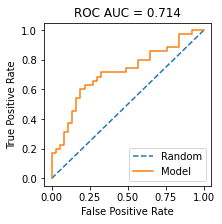

In [445]:
model = catboost.CatBoostClassifier(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
probs = model.predict_proba(X_valid)
roc_auc_create(probs, y_valid)

LogReg, SVC, MLP, RandomForest работают лучше всего из коробки, нужно попробавать подобрать гиперпараметры

# Протестируем нейросети

In [14]:
def history_loss_metrics(history):
    logs = pd.DataFrame(history)

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
    plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(logs.loc[5:,"auc"], lw=2, label='training ROC AUC score')
    plt.plot(logs.loc[5:,"val_auc"], lw=2, label='validation ROC AUC score')
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")
    plt.legend(loc='lower right')
    plt.show()

In [40]:
def roc_auc_create_nn(probs, y_valid):
    probs = probs.T[0]
    fpr, tpr, threshold = roc_curve(y_valid, probs)
    roc_auc = roc_auc_score(y_valid, probs)
    plt.figure(figsize=(3, 3))
    plt.plot([0, 1], label='Random', linestyle='--')
    plt.plot(fpr, tpr, label = 'Model')
    plt.title('ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

**NN_v_1**

In [561]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(L.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="sigmoid"))

Добавим регуляризацию и дропаут слои для предотвращения переобучения

In [562]:
# Compile model
optimizer = tf.keras.optimizers.Adam(ExponentialDecay(1e-2, 100, 0.9))
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['AUC'])

In [563]:
checkpoint = ModelCheckpoint(
    'networks/nn1.hdf5', monitor='val_loss',
                    save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_loss', patience=100, restore_best_weights=True, mode='min') 
callbacks_list = [checkpoint, earlystop]

In [564]:
history = model.fit(X_train, y_train,
                    epochs=10000, # обучаем пока EarlyStopping не остановит обучение
                    batch_size=X_train.shape[0],
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/10000
1/1 [==============================] - 0s 256ms/step - loss: 1.3072 - auc: 0.5154 - val_loss: 5.8663 - val_auc: 0.5000
Epoch 2/10000
1/1 [==============================] - 0s 57ms/step - loss: 5.9440 - auc: 0.5003 - val_loss: 1.5695 - val_auc: 0.5421
Epoch 3/10000
1/1 [==============================] - 0s 53ms/step - loss: 1.6094 - auc: 0.5318 - val_loss: 1.1367 - val_auc: 0.4668
Epoch 4/10000
1/1 [==============================] - 0s 52ms/step - loss: 1.1382 - auc: 0.4829 - val_loss: 1.1093 - val_auc: 0.4884
Epoch 5/10000
1/1 [==============================] - 0s 49ms/step - loss: 1.1100 - auc: 0.4981 - val_loss: 1.0604 - val_auc: 0.5552
Epoch 6/10000
1/1 [==============================] - 0s 43ms/step - loss: 1.0647 - auc: 0.5020 - val_loss: 1.0446 - val_auc: 0.5954
Epoch 7/10000
1/1 [==============================] - 0s 44ms/step - loss: 1.0596 - auc: 0.4758 - val_loss: 1.0305 - val_auc: 0.5807
Epoch 8/10000
1/1 [==============================] - 0s 17ms/step - loss: 1

1/1 [==============================] - 0s 12ms/step - loss: 0.7825 - auc: 0.6368 - val_loss: 0.7563 - val_auc: 0.7309
Epoch 63/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.7841 - auc: 0.6433 - val_loss: 0.7528 - val_auc: 0.7386
Epoch 64/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.7906 - auc: 0.6168 - val_loss: 0.7471 - val_auc: 0.7359
Epoch 65/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.7794 - auc: 0.6152 - val_loss: 0.7487 - val_auc: 0.7347
Epoch 66/10000
1/1 [==============================] - 0s 46ms/step - loss: 0.7708 - auc: 0.6651 - val_loss: 0.7461 - val_auc: 0.7382
Epoch 67/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.7692 - auc: 0.6588 - val_loss: 0.7407 - val_auc: 0.7375
Epoch 68/10000
1/1 [==============================] - 0s 41ms/step - loss: 0.7741 - auc: 0.6307 - val_loss: 0.7369 - val_auc: 0.7286
Epoch 69/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.7762 - 

1/1 [==============================] - 0s 13ms/step - loss: 0.6707 - auc: 0.7149 - val_loss: 0.6659 - val_auc: 0.7290
Epoch 124/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.6708 - auc: 0.7007 - val_loss: 0.6665 - val_auc: 0.7220
Epoch 125/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.6457 - auc: 0.7293 - val_loss: 0.6646 - val_auc: 0.7247
Epoch 126/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.6708 - auc: 0.6905 - val_loss: 0.6645 - val_auc: 0.7355
Epoch 127/10000
1/1 [==============================] - ETA: 0s - loss: 0.6623 - auc: 0.724 - 0s 12ms/step - loss: 0.6623 - auc: 0.7247 - val_loss: 0.6648 - val_auc: 0.7236
Epoch 128/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.6638 - auc: 0.7057 - val_loss: 0.6586 - val_auc: 0.7251
Epoch 129/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.6668 - auc: 0.7058 - val_loss: 0.6586 - val_auc: 0.7166
Epoch 130/10000
1/1 [===================

Epoch 184/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.6182 - auc: 0.7272 - val_loss: 0.6742 - val_auc: 0.7097
Epoch 185/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.6152 - auc: 0.7396 - val_loss: 0.6585 - val_auc: 0.7286
Epoch 186/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6013 - auc: 0.7454 - val_loss: 0.6483 - val_auc: 0.7340
Epoch 187/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.6074 - auc: 0.7275 - val_loss: 0.6411 - val_auc: 0.7429
Epoch 188/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.6115 - auc: 0.7304 - val_loss: 0.6565 - val_auc: 0.7502
Epoch 189/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6158 - auc: 0.7294 - val_loss: 0.6527 - val_auc: 0.7375
Epoch 190/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6093 - auc: 0.7302 - val_loss: 0.6472 - val_auc: 0.7320
Epoch 191/10000
1/1 [==============================] - 0s 15ms

1/1 [==============================] - 0s 14ms/step - loss: 0.5775 - auc: 0.7285 - val_loss: 0.6755 - val_auc: 0.7336
Epoch 246/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.5887 - auc: 0.7329 - val_loss: 0.6599 - val_auc: 0.6977
Epoch 247/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.5850 - auc: 0.7368 - val_loss: 0.6681 - val_auc: 0.6873
Epoch 248/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.5730 - auc: 0.7475 - val_loss: 0.6688 - val_auc: 0.7181
Epoch 249/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.5709 - auc: 0.7187 - val_loss: 0.6661 - val_auc: 0.7189
Epoch 250/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.5573 - auc: 0.7484 - val_loss: 0.6535 - val_auc: 0.7135
Epoch 251/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.5758 - auc: 0.7394 - val_loss: 0.6555 - val_auc: 0.7212
Epoch 252/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.

1/1 [==============================] - 0s 40ms/step - loss: 0.5662 - auc: 0.7414 - val_loss: 0.5872 - val_auc: 0.7564
Epoch 307/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.5659 - auc: 0.7429 - val_loss: 0.5918 - val_auc: 0.7413
Epoch 308/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.5791 - auc: 0.7237 - val_loss: 0.6032 - val_auc: 0.7328
Epoch 309/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.5751 - auc: 0.7307 - val_loss: 0.6106 - val_auc: 0.7421
Epoch 310/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.5841 - auc: 0.7380 - val_loss: 0.6130 - val_auc: 0.7359
Epoch 311/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.5669 - auc: 0.7448 - val_loss: 0.6192 - val_auc: 0.7174
Epoch 312/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.5878 - auc: 0.7278 - val_loss: 0.6093 - val_auc: 0.7093
Epoch 313/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.

1/1 [==============================] - 0s 13ms/step - loss: 0.5241 - auc: 0.7972 - val_loss: 0.6253 - val_auc: 0.7560
Epoch 368/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.5375 - auc: 0.7787 - val_loss: 0.6216 - val_auc: 0.7625
Epoch 369/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.5181 - auc: 0.8031 - val_loss: 0.6322 - val_auc: 0.7371
Epoch 370/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.5136 - auc: 0.7907 - val_loss: 0.6545 - val_auc: 0.7332
Epoch 371/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.5153 - auc: 0.7851 - val_loss: 0.6449 - val_auc: 0.7112
Epoch 372/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.5195 - auc: 0.7730 - val_loss: 0.6263 - val_auc: 0.7351
Epoch 373/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.5186 - auc: 0.7914 - val_loss: 0.6208 - val_auc: 0.7347
Epoch 374/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.

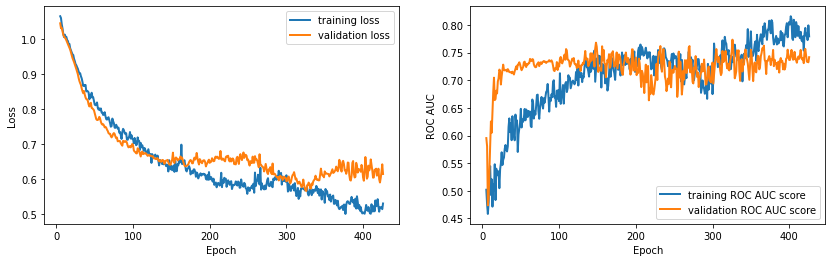

In [565]:
history_loss_metrics(history.history)

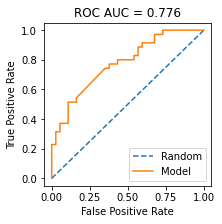

In [566]:
probs = model.predict_proba(X_valid)
roc_auc_create_nn(probs, y_valid)

Классическая сеть дает средний результат

**NN_v_2**

Разобьем данные по командам

In [379]:
scaler2 = MinMaxScaler()

In [380]:
X_comb = df.drop(['sample', 'who_win', 'map_name', 'map_id', 'team1_id', 'team2_id'], axis=1)
y_comb = df['who_win'].values # целевой признак

In [381]:
team1_cols = [x for x in X_comb.columns if 'team1' in x]
team2_cols = [x for x in X_comb.columns if 'team2' in x]

In [382]:
len(X_comb.columns)

280

In [383]:
# отсортируем колонки
X_comb = X_comb[team1_cols + team2_cols]

In [384]:
X_comb = scaler2.fit_transform(X_comb)

In [385]:
X_comb_team1 = X_comb[:,:140]
X_comb_team2 = X_comb[:,140:]

In [386]:
# разделим трейн и тест
X_comb_team1_main = X_comb_team1[:-30]
X_comb_team1_test = X_comb_team1[-30:]
X_comb_team2_main = X_comb_team2[:-30]
X_comb_team2_test = X_comb_team2[-30:]

y_comb = y_comb[:-30]

In [387]:
from random import sample
# рандомные индексы для валидации на 10%
list_idx = sample(range(0, 713), 71)

In [388]:
# индексы для трейн
all_idx = [x for x in range(0, 713)]
train_idx = [x for x in all_idx if x not in list_idx]

In [389]:
X_valid_comb_team1 = X_comb_team1_main[list_idx]
X_valid_comb_team2 = X_comb_team2_main[list_idx]
X_train_comb_team1 = X_comb_team1_main[train_idx]
X_train_comb_team2 = X_comb_team2_main[train_idx]

y_valid_comb = y_comb[list_idx]
y_train_comb = y_comb[train_idx]

составим и обучим multiinput сеть

In [427]:
model_team1 = Sequential()
model_team1.add(L.Dense(256, input_dim=X_train_comb_team1.shape[1], activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model_team1.add(L.Dropout(0.5))
model_team1.add(L.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model_team1.add(L.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model_team1.add(L.Dropout(0.5))

In [428]:
model_team1 = Sequential()
model_team1.add(L.Dense(256, input_dim=X_train_comb_team2.shape[1], activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model_team1.add(L.Dropout(0.5))
model_team1.add(L.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model_team1.add(L.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model_team1.add(L.Dropout(0.5))

In [429]:
# объединим слои в голове
combinedInput = L.concatenate([model_team1.output, model_team2.output])
# being our regression head
head = L.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(combinedInput)
head = L.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(head)
head = L.Dense(1, activation="sigmoid")(head)

model = Model(inputs=[model_team1.input, model_team2.input], outputs=head)

In [430]:
model.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_188_input (InputLayer)    [(None, 140)]        0                                            
__________________________________________________________________________________________________
dense_188 (Dense)               (None, 256)          36096       dense_188_input[0][0]            
__________________________________________________________________________________________________
dropout_72 (Dropout)            (None, 256)          0           dense_188[0][0]                  
__________________________________________________________________________________________________
dense_134_input (InputLayer)    [(None, 140)]        0                                            
______________________________________________________________________________________

In [431]:
# Compile model
optimizer = tf.keras.optimizers.Adam(ExponentialDecay(1e-2, 100, 0.9))
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['AUC'])

In [432]:
checkpoint = ModelCheckpoint(
    'networks/nn2.hdf5', monitor='val_loss',
                    save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_loss', patience=100, restore_best_weights=True, mode='min') 
callbacks_list = [checkpoint, earlystop]

In [433]:
history = model.fit((X_train_comb_team1, X_train_comb_team2), y_train_comb,
                    epochs=10000, # обучаем пока EarlyStopping не остановит обучение
                    batch_size=X_train_comb_team1.shape[0],
                    validation_data=((X_valid_comb_team1, X_valid_comb_team2), y_valid_comb),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/10000
1/1 [==============================] - 0s 234ms/step - loss: 1.4714 - auc: 0.5111 - val_loss: 1.4680 - val_auc: 0.5180
Epoch 2/10000
1/1 [==============================] - 0s 61ms/step - loss: 1.5669 - auc: 0.5033 - val_loss: 1.3384 - val_auc: 0.4667
Epoch 3/10000
1/1 [==============================] - 0s 64ms/step - loss: 1.3561 - auc: 0.4919 - val_loss: 1.2140 - val_auc: 0.4780
Epoch 4/10000
1/1 [==============================] - 0s 59ms/step - loss: 1.2167 - auc: 0.5248 - val_loss: 1.1514 - val_auc: 0.4920
Epoch 5/10000
1/1 [==============================] - 0s 65ms/step - loss: 1.1501 - auc: 0.5650 - val_loss: 1.0997 - val_auc: 0.5837
Epoch 6/10000
1/1 [==============================] - 0s 63ms/step - loss: 1.0986 - auc: 0.5555 - val_loss: 1.0563 - val_auc: 0.5761
Epoch 7/10000
1/1 [==============================] - 0s 62ms/step - loss: 1.0565 - auc: 0.5357 - val_loss: 1.0210 - val_auc: 0.5693
Epoch 8/10000
1/1 [==============================] - 0s 56ms/step - loss: 1

1/1 [==============================] - 0s 58ms/step - loss: 0.7202 - auc: 0.6014 - val_loss: 0.7185 - val_auc: 0.5713
Epoch 63/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.7020 - auc: 0.6204 - val_loss: 0.7189 - val_auc: 0.5601
Epoch 64/10000
1/1 [==============================] - 0s 61ms/step - loss: 0.7039 - auc: 0.6192 - val_loss: 0.7182 - val_auc: 0.5585
Epoch 65/10000
1/1 [==============================] - 0s 56ms/step - loss: 0.6950 - auc: 0.6591 - val_loss: 0.7181 - val_auc: 0.5501
Epoch 66/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.7044 - auc: 0.6380 - val_loss: 0.7208 - val_auc: 0.5337
Epoch 67/10000
1/1 [==============================] - 0s 59ms/step - loss: 0.6966 - auc: 0.6484 - val_loss: 0.7154 - val_auc: 0.5537
Epoch 68/10000
1/1 [==============================] - 0s 57ms/step - loss: 0.6908 - auc: 0.6594 - val_loss: 0.7153 - val_auc: 0.5473
Epoch 69/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.6999 - 

1/1 [==============================] - 0s 16ms/step - loss: 0.6604 - auc: 0.6741 - val_loss: 0.7125 - val_auc: 0.5417
Epoch 124/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6755 - auc: 0.6598 - val_loss: 0.7058 - val_auc: 0.5489
Epoch 125/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.6511 - auc: 0.7029 - val_loss: 0.7056 - val_auc: 0.5369
Epoch 126/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.6463 - auc: 0.6855 - val_loss: 0.7108 - val_auc: 0.5489
Epoch 127/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.6650 - auc: 0.6666 - val_loss: 0.7102 - val_auc: 0.5465
Epoch 128/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6783 - auc: 0.6494 - val_loss: 0.7001 - val_auc: 0.5481
Epoch 129/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6572 - auc: 0.6807 - val_loss: 0.7136 - val_auc: 0.5457
Epoch 130/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.

1/1 [==============================] - 0s 15ms/step - loss: 0.6679 - auc: 0.6775 - val_loss: 0.7069 - val_auc: 0.5789
Epoch 185/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.6545 - auc: 0.6906 - val_loss: 0.7279 - val_auc: 0.5160
Epoch 186/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.6563 - auc: 0.6785 - val_loss: 0.7006 - val_auc: 0.5829
Epoch 187/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6680 - auc: 0.6595 - val_loss: 0.6989 - val_auc: 0.5845
Epoch 188/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.6439 - auc: 0.7016 - val_loss: 0.6964 - val_auc: 0.5837
Epoch 189/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.6423 - auc: 0.7096 - val_loss: 0.6938 - val_auc: 0.5737
Epoch 190/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.6478 - auc: 0.6926 - val_loss: 0.6946 - val_auc: 0.5645
Epoch 191/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.

1/1 [==============================] - 0s 13ms/step - loss: 0.6579 - auc: 0.6889 - val_loss: 0.6970 - val_auc: 0.6142
Epoch 246/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.6344 - auc: 0.7228 - val_loss: 0.7063 - val_auc: 0.6010
Epoch 247/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.6509 - auc: 0.7035 - val_loss: 0.7080 - val_auc: 0.5268
Epoch 248/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.6597 - auc: 0.6446 - val_loss: 0.7052 - val_auc: 0.5224
Epoch 249/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.6667 - auc: 0.6292 - val_loss: 0.7028 - val_auc: 0.5276
Epoch 250/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.6531 - auc: 0.6801 - val_loss: 0.6968 - val_auc: 0.5705
Epoch 251/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6587 - auc: 0.6573 - val_loss: 0.6929 - val_auc: 0.5853
Epoch 252/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.

1/1 [==============================] - 0s 12ms/step - loss: 0.6366 - auc: 0.6890 - val_loss: 0.6917 - val_auc: 0.5889
Epoch 307/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.6242 - auc: 0.7122 - val_loss: 0.6897 - val_auc: 0.5829
Epoch 308/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.6293 - auc: 0.7031 - val_loss: 0.6856 - val_auc: 0.5970
Epoch 309/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.6271 - auc: 0.7077 - val_loss: 0.6856 - val_auc: 0.5998
Epoch 310/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.6450 - auc: 0.6771 - val_loss: 0.6862 - val_auc: 0.5974
Epoch 311/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6103 - auc: 0.7145 - val_loss: 0.6935 - val_auc: 0.6046
Epoch 312/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6373 - auc: 0.6999 - val_loss: 0.6863 - val_auc: 0.6066
Epoch 313/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.

1/1 [==============================] - 0s 15ms/step - loss: 0.6413 - auc: 0.6724 - val_loss: 0.6994 - val_auc: 0.5793
Epoch 368/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6317 - auc: 0.6985 - val_loss: 0.6967 - val_auc: 0.5825
Epoch 369/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6249 - auc: 0.7080 - val_loss: 0.7225 - val_auc: 0.5304
Epoch 370/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.5918 - auc: 0.7361 - val_loss: 0.7552 - val_auc: 0.5196
Epoch 371/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6671 - auc: 0.6641 - val_loss: 0.7046 - val_auc: 0.5377
Epoch 372/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.6135 - auc: 0.7268 - val_loss: 0.6976 - val_auc: 0.5645
Epoch 373/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.6443 - auc: 0.6648 - val_loss: 0.6903 - val_auc: 0.5777
Epoch 374/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.

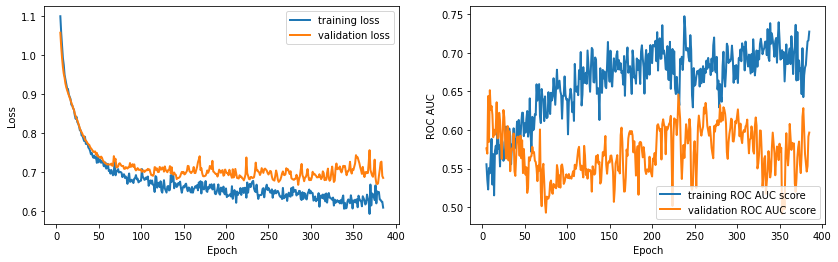

In [434]:
history_loss_metrics(history.history)

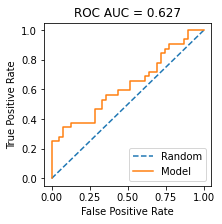

In [435]:
probs = model.predict([X_valid_comb_team1, X_valid_comb_team2])
roc_auc_create_nn(probs, y_valid_comb)

Двухвходная модель не показывает высоких результатов

# Подберем гиперпараметры

Для алгоритмов с наилучшим показателем из коробки

**LogisticRegression**

In [486]:
model = LogisticRegression()

In [487]:
GSCV = GridSearchCV(model, {"penalty": ['l1', 'l2', 'elasticnet', 'none'],
                            "tol": [1e-4, 1e-3, 1e-5], "solver": ['sag', 'lbfgs'],
                            "C": [100, 10, 1.0, 0.1, 0.01]},
                    cv = 5, scoring = 'roc_auc')

In [488]:
GSCV.fit(X_main,y)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['sag', 'lbfgs'],
                         'tol': [0.0001, 0.001, 1e-05]},
             scoring='roc_auc')

In [489]:
GSCV.best_estimator_

LogisticRegression(C=0.01, solver='sag')

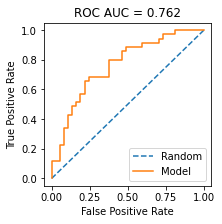

In [490]:
y_pred = GSCV.predict(X_valid)
probs = GSCV.predict_proba(X_valid)
roc_auc_create(probs, y_valid)

In [491]:
pickle.dump(GSCV, open('models/LogReg_0_762.pkl', 'wb'))

модель из коробки работает лучше

**MLPClassifier**

In [478]:
model = MLPClassifier()

In [479]:
GSCV = GridSearchCV(model, {'hidden_layer_sizes': [(10,30,10),(20,)],
                            'activation': ['tanh', 'relu'],
                            'solver': ['sgd', 'adam'],
                            'alpha': [0.0001, 0.01, 0.00001],
                            'learning_rate': ['constant','adaptive'],},
                    cv = 5, scoring = 'roc_auc')

In [480]:
GSCV.fit(X_main,y)

GridSearchCV(cv=3, estimator=MLPClassifier(),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.01, 1e-05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [50, 100, 200, 500],
                         'solver': ['sgd', 'adam']},
             scoring='roc_auc')

In [481]:
GSCV.best_estimator_

MLPClassifier(activation='tanh', hidden_layer_sizes=(20,),
              learning_rate='adaptive', max_iter=50)

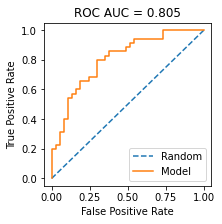

In [482]:
y_pred = GSCV.predict(X_valid)
probs = GSCV.predict_proba(X_valid)
roc_auc_create(probs, y_valid)

In [485]:
pickle.dump(GSCV, open('models/MLP_0_805.pkl', 'wb'))

MLP лучшая модель ROC_AUC=0.805

**SVC**

In [492]:
model = SVC(probability=True)

In [493]:
GSCV = GridSearchCV(model, {'C': [0.1,1, 10, 100],
                            'gamma': [1,0.1,0.01,0.001],
                            'kernel': ['rbf', 'poly', 'sigmoid']},
                    cv = 5, scoring = 'roc_auc')

In [494]:
GSCV.fit(X_main,y)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='roc_auc')

In [495]:
GSCV.best_estimator_

SVC(C=100, gamma=0.001, probability=True)

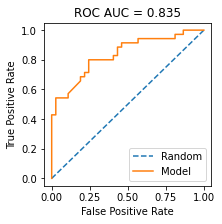

In [496]:
y_pred = GSCV.predict(X_valid)
probs = GSCV.predict_proba(X_valid)
roc_auc_create(probs, y_valid)

In [498]:
pickle.dump(GSCV, open('models/SVC_0_835.pkl', 'wb'))

SVC лучшая модель ROC_AUC=0.835

**RandomForestClassifier**

In [499]:
model = RandomForestClassifier()

In [500]:
GSCV = GridSearchCV(model, {'bootstrap': [True],
                            'max_depth': [80, 90, 100, 110],
                            'max_features': [2, 3, 4],
                            'min_samples_leaf': [3, 4, 5],
                            'min_samples_split': [8, 10, 12],
                            'n_estimators': [100, 200, 300, 1000]},
                    cv = 5, scoring = 'roc_auc')

In [501]:
GSCV.fit(X_main,y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             scoring='roc_auc')

In [502]:
GSCV.best_estimator_

RandomForestClassifier(max_depth=110, max_features=3, min_samples_leaf=5,
                       min_samples_split=12)

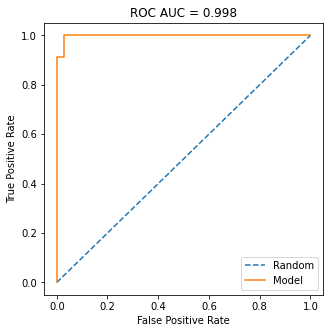

In [528]:
y_pred = GSCV.predict(X_valid)
probs = GSCV.predict_proba(X_valid)
roc_auc_create(probs, y_valid)

In [517]:
accuracy_score(y_valid, y_pred)

0.9583333333333334

In [518]:
pickle.dump(GSCV, open('models/RFC_0_998.pkl', 'wb'))

Крайне высокий результат, при том, что использовалась кросс-валидация... попробуем поменить выборку для теста и проверить метрики

In [519]:
list_idx = sample(range(0, 713), 150)

In [522]:
X_valid_2 = X_main[list_idx]

In [524]:
y_valid_2 = y[list_idx]

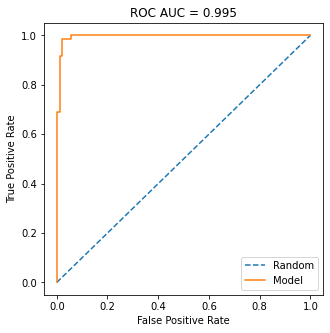

In [529]:
y_pred_2 = GSCV.predict(X_valid_2)
probs_2 = GSCV.predict_proba(X_valid_2)
roc_auc_create(probs_2, y_valid_2)

In [526]:
accuracy_score(y_valid_2, y_pred_2)

0.98

In [546]:
probs_2

array([[0.67809604, 0.32190396],
       [0.55808121, 0.44191879],
       [0.63251538, 0.36748462],
       [0.34175126, 0.65824874],
       [0.18814338, 0.81185662],
       [0.34570873, 0.65429127],
       [0.3861628 , 0.6138372 ],
       [0.68035162, 0.31964838],
       [0.37376907, 0.62623093],
       [0.38688803, 0.61311197],
       [0.62333883, 0.37666117],
       [0.81864038, 0.18135962],
       [0.6352546 , 0.3647454 ],
       [0.28933163, 0.71066837],
       [0.44806259, 0.55193741],
       [0.62130571, 0.37869429],
       [0.26915162, 0.73084838],
       [0.33732404, 0.66267596],
       [0.69785147, 0.30214853],
       [0.6988782 , 0.3011218 ],
       [0.6332488 , 0.3667512 ],
       [0.80561706, 0.19438294],
       [0.6140855 , 0.3859145 ],
       [0.24834002, 0.75165998],
       [0.44292468, 0.55707532],
       [0.38609677, 0.61390323],
       [0.39046771, 0.60953229],
       [0.65039034, 0.34960966],
       [0.66452128, 0.33547872],
       [0.69458832, 0.30541168],
       [0.

Также крайне высокий результат, модель переобучилась, т.к. слишком мало данных

# Сделаем предсказание

In [542]:
test['who_win_proba'] = 0.0

## Инициализируем лучшие модели

**RandomForestClassifier - best model**

In [536]:
rfc = pickle.load(open('models/RFC_0_998.pkl', 'rb'))

In [578]:
rfc_proba = rfc.predict_proba(X_test)[:,1]

In [579]:
np.std(rfc_proba)

0.05799783495046198

**SVC**

In [547]:
svc = pickle.load(open('models/SVC_0_835.pkl', 'rb'))

In [580]:
svc_proba = svc.predict_proba(X_test)[:,1]

In [581]:
np.std(svc_proba)

0.07013402672554696

**MLP**

In [557]:
mlp = pickle.load(open('models/MLP_0_805.pkl', 'rb'))

In [582]:
mlp_proba = mlp.predict_proba(X_test)[:,1]

In [583]:
np.std(mlp_proba)

0.09736485270409277

**NN**

In [567]:
nn = Sequential()
nn.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
nn.add(L.Dropout(0.5))
nn.add(L.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
nn.add(L.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
nn.add(L.Dropout(0.5))
nn.add(L.Dense(1, activation="sigmoid"))

In [568]:
nn.load_weights('networks/nn1.hdf5')

In [584]:
nn_proba = nn.predict(X_test)

In [585]:
np.std(nn_proba)

0.20790668

Многие модели делают крайне близкие предсказания для теста

## Предскажем test

**Ансамбль всех моделей**

In [586]:
test_sub_all_models = test.copy()

In [590]:
test_sub_all_models['who_win_proba'] = (rfc_proba + svc_proba + mlp_proba + nn_proba) / 4

In [595]:
test_sub_all_models.to_csv('subs/test_sub_all_models.csv', index=False)

**Ансамбль random forest + network**

In [596]:
test_sub_rfc_nn = test.copy()

In [597]:
test_sub_rfc_nn['who_win_proba'] = (rfc_proba + nn_proba) / 2

In [599]:
test_sub_rfc_nn.to_csv('subs/test_sub_rfc_nn.csv', index=False)

**Ансамбль svc + mlp**

In [600]:
test_sub_svc_mlp = test.copy()

In [601]:
test_sub_svc_mlp['who_win_proba'] = (svc_proba + mlp_proba) / 2

In [603]:
test_sub_svc_mlp.to_csv('subs/test_sub_svc_mlp.csv', index=False)